# Redundant Calibration Nightly Data Quality Notebook

**Josh Dillon**, Last Revised 10/25/20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from hera_cal import io, redcal, apply_cal
from hera_qm.metrics_io import load_metric_file
import glob
import os
from copy import deepcopy
import inspect
import h5py
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.

# JD = "2459117"
# data_path = '/lustre/aoc/projects/hera/H4C/2459117'
# ant_metrics_ext = ".maybe_good.ant_metrics.hdf5"
# prefix = ".maybe_good"
# os.environ["JULIANDATE"] = JD
# os.environ["DATA_PATH"] = data_path
# os.environ["ANT_METRICS_EXT"] = ant_metrics_ext
# os.environ["OMNI_PREFIX"] = prefix

In [3]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
ant_metrics_ext = os.environ['ANT_METRICS_EXT']
try: 
    prefix = os.environ["OMNI_PREFIX"]
except:
    prefix = ant_metrics_ext.replace('.ant_metrics.hdf5', '')
print(f'JD = "{JD}"')
print(f'data_path = "{data_path}"')
print(f'ant_metrics_ext = "{ant_metrics_ext}"')
print(f'prefix = "{prefix}"')

JD = "2459697"
data_path = "/mnt/sn1/2459697"
ant_metrics_ext = ".ant_metrics.hdf5"
prefix = ".known_good"


In [4]:
from astropy.time import Time
utc = Time(JD, format='jd').datetime
print(f'Date: {utc.month}-{utc.day}-{utc.year}')

Date: 4-27-2022


In [5]:
print('Looking for data in', data_path, 'on JD', JD)
data_list = sorted(glob.glob(os.path.join(data_path, 'zen.{}.?????.sum.uvh5'.format(JD))))
if len(data_list) == 0:
    data_list = sorted(glob.glob(os.path.join(data_path, 'zen.{}.?????.uvh5'.format(JD))))
print('Found {} data files.'.format(len(data_list)))

# If only a subset of the data files have redcal run on them, then only look at those files
data_list = [df for df in data_list if os.path.exists(df.replace('.uvh5', f'{prefix}.omni.calfits'))]
print('Found {} data files with corresponding redcal solutions.'.format(len(data_list)))

Looking for data in /mnt/sn1/2459697 on JD 2459697
Found 797 data files.
Found 80 data files with corresponding redcal solutions.


# Load Single File

In [6]:
# Pick middle of the night data file to examine
example_file = data_list[len(data_list)//2]
file_JD = '.'.join([s for s in example_file.split('.') if s.isdigit()])

In [7]:
# controls how many redundant baseline groups to plot. 
# 2 means the most common ee- and nn-polarized baseline.
n_reds_to_plot = 2  

In [8]:
# Load omnical gains and determine ex_ants
hc = io.HERACal(example_file.replace('.uvh5', f'{prefix}.omni.calfits'))
gains, gain_flags, _, _ = hc.read()
ex_ants = [ant for ant in gain_flags if np.all(gain_flags[ant])]

# Load the most common redundant baselines and calibrate
hd = io.HERAData(example_file)
reds = redcal.get_reds({ant: hd.antpos[ant] for ant in hd.data_ants}, pols=['ee', 'nn'])
red_bl_map = {bl: red[0] for red in reds for bl in red} 
reds = redcal.filter_reds(reds, ex_ants=ex_ants)
reds = sorted(reds, key=len, reverse=True)
data, flags, nsamples = hd.read(
    bls=[bl for red in reds[0:n_reds_to_plot] for bl in red])
apply_cal.calibrate_in_place(data, gains, data_flags=flags, cal_flags=gain_flags)

# Load omnical visibility solutions
hdo = io.HERAData(example_file.replace('.uvh5', f'{prefix}.omni_vis.uvh5'))
omni_data, omni_flags, omni_nsamples = hdo.read(
    bls=[red_bl_map[red[0]] for red in reds[0:n_reds_to_plot]])

# Inspect Single File

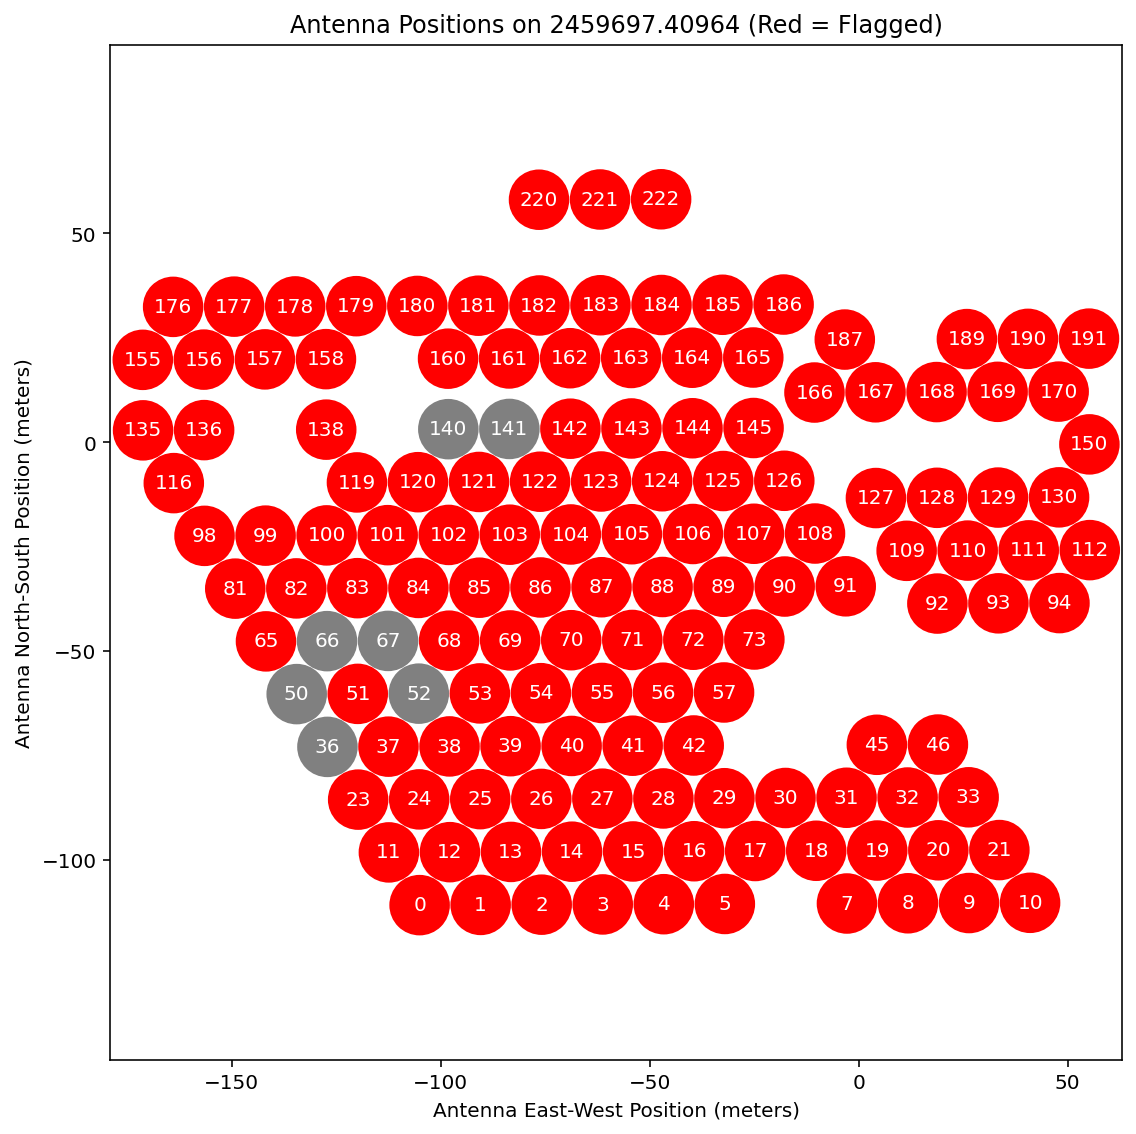

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(np.array([hd.antpos[ant][0] for ant in hd.data_ants]), 
            np.array([hd.antpos[ant][1] for ant in hd.data_ants]), c='w', s=0)
for ant in hd.data_ants:
    pos = hd.antpos[ant]
    bad = ant in [ant[0] for ant in ex_ants]
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("Antenna East-West Position (meters)")
plt.ylabel("Antenna North-South Position (meters)")
plt.title('Antenna Positions on {} (Red = Flagged)'.format(file_JD));
plt.axis('equal')
plt.tight_layout()
plt.show()

### Figure 1: Array and Flagged Antennas

#### OBSERVER CHECKLIST:
* Check that the array configuration looks reasonable.
* Check that all flags expected to be flagged are actually flagged but also that not everything is getting flagged.

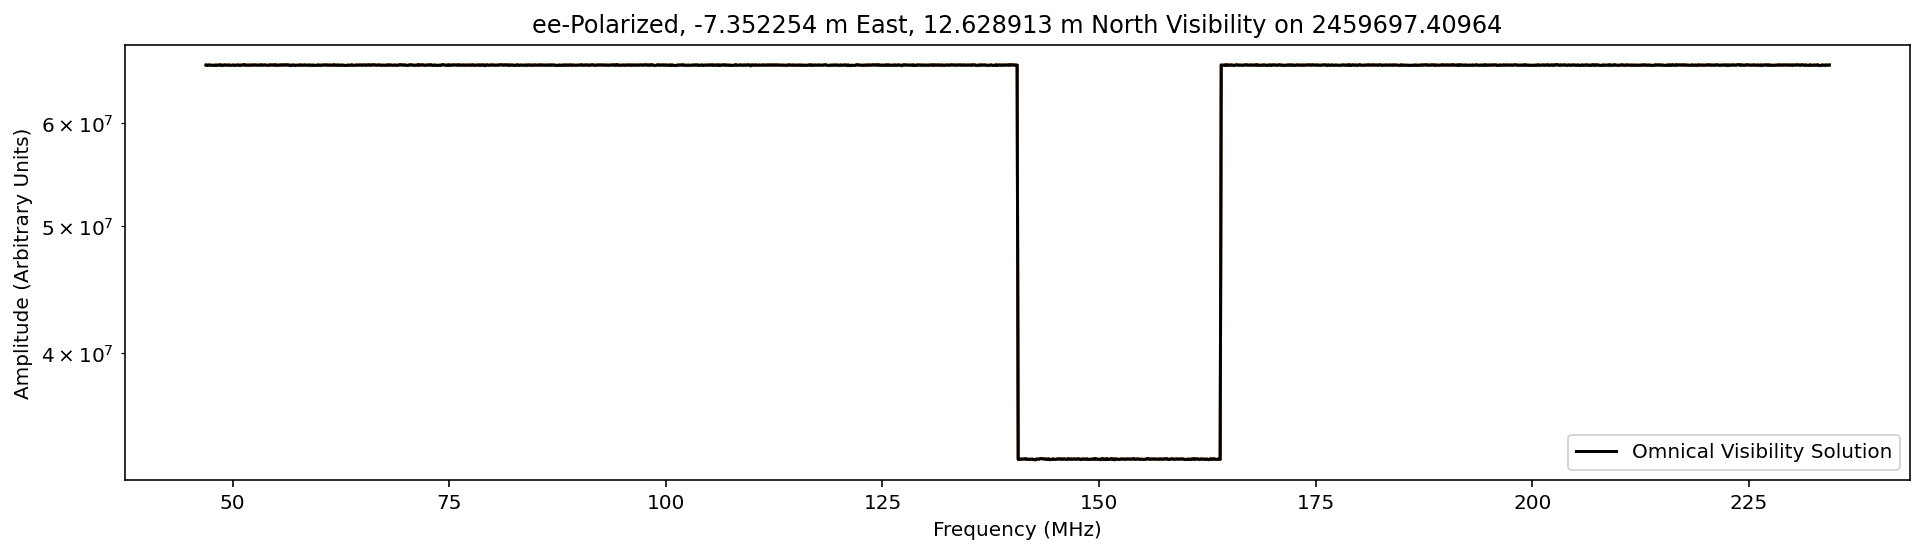

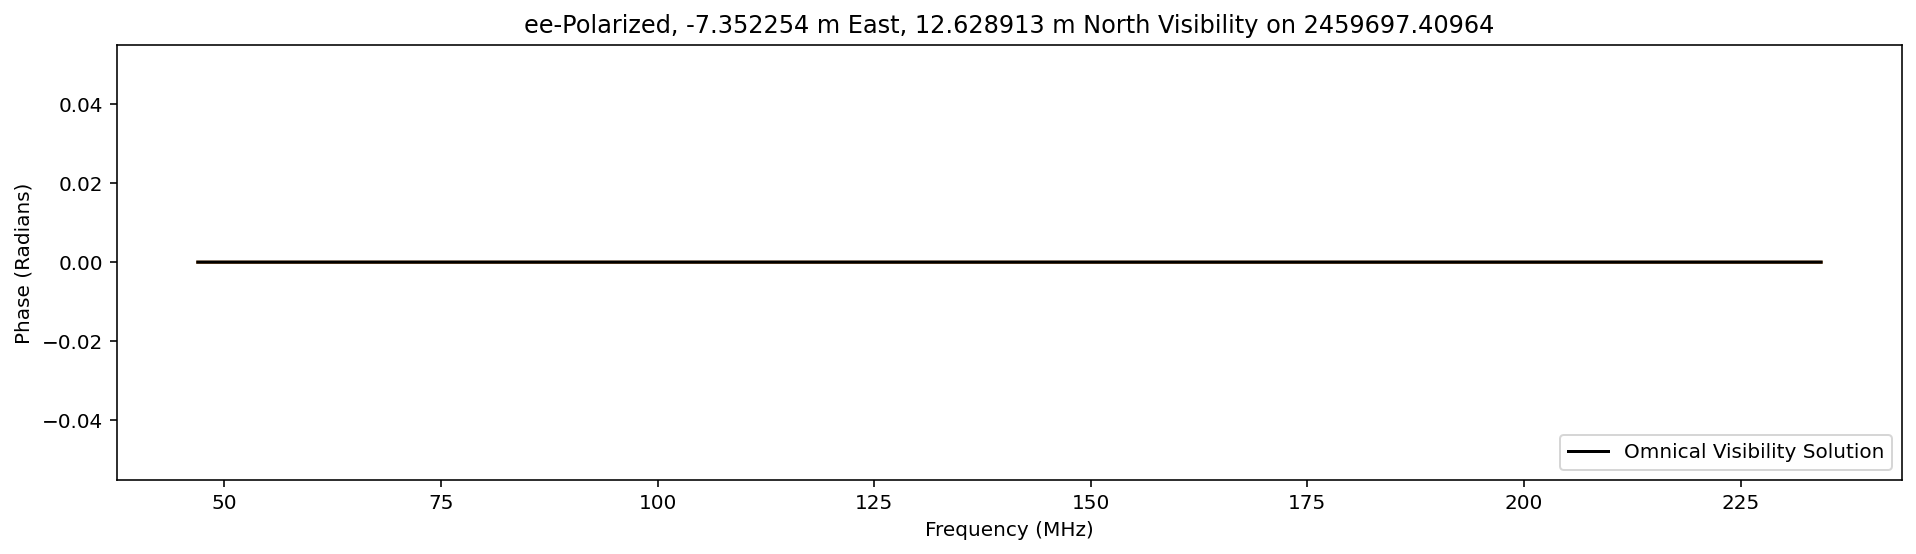

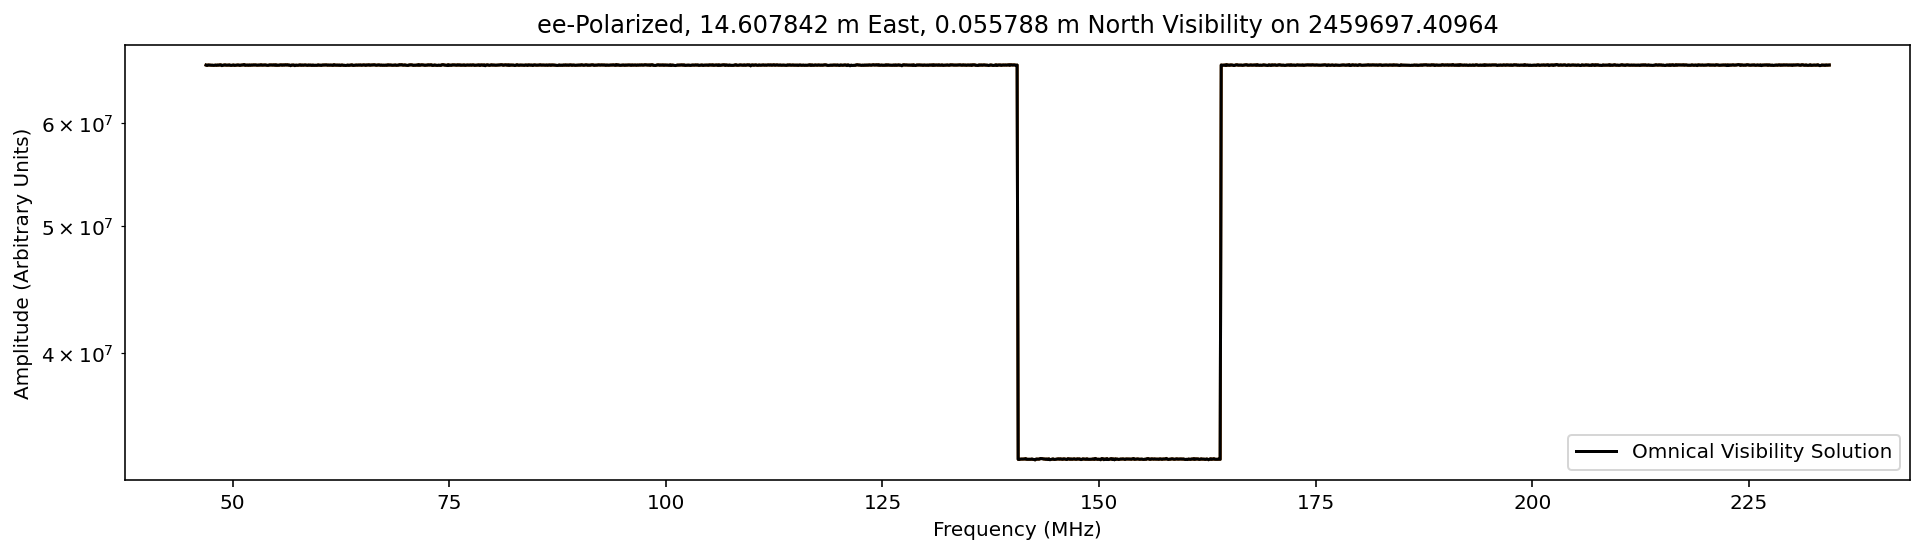

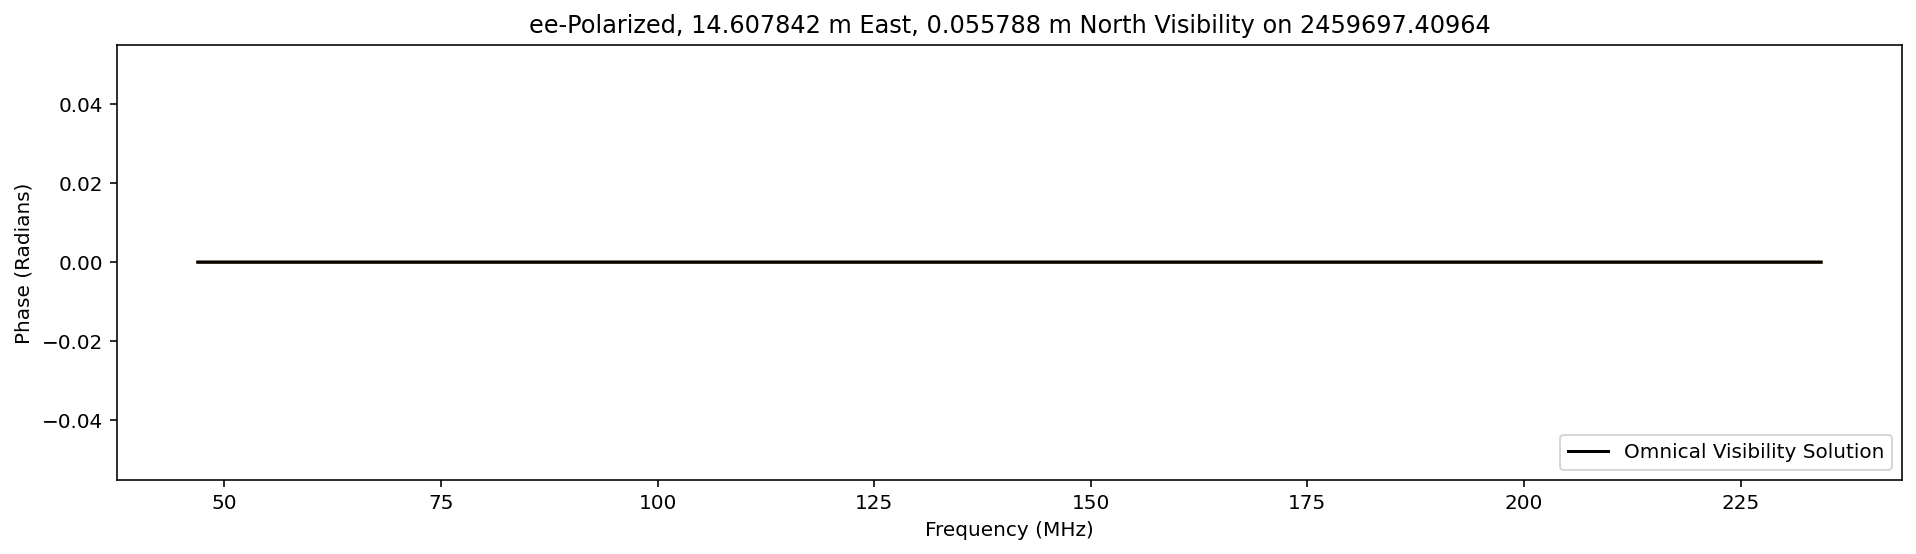

In [10]:
# Plot redundant groups
for red in reds[0:n_reds_to_plot]:
    blvec = hd.antpos[red[0][1]] - hd.antpos[red[0][0]]
    for func, plot, ylabel in zip([np.abs, np.angle], [plt.semilogy, plt.plot], ['Amplitude (Arbitrary Units)', 'Phase (Radians)']):
        plt.figure(figsize=(16,4))
        for bl in red:
            plot(hd.freqs/1e6, func(np.median(data[bl], axis=0)))
        plot(hd.freqs/1e6, func(np.median(omni_data[red_bl_map[red[0]]], axis=0)), 'k-', label='Omnical Visibility Solution')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel(ylabel)
        plt.legend(loc='lower right')
        plt.title('{}-Polarized, {:f} m East, {:f} m North Visibility on {}'.format(red[0][2], blvec[0], blvec[1], file_JD))

### Figure 2: Example redundant baseline groups and omnical visibility solution for a single file.


#### OBSERVER CHECKLIST:
* Check that that there actually is something plotted and the data isn't all flagged somehow.
* Check whether most of the baselines cluster together and that the black line follows the cluster.
* Check whether there are any significant outliers (though it won't be clear as yet which antennas those are attributable to, see below).

# Load Whole Day

In [11]:
# load all redcal metadata into dictionaries 
ee_iters_dict = {}
nn_iters_dict = {}
dlys_dict = {}
flips_dict = {}
times_dict = {}
lsts_dict = {}
histories_dict = {}
ants = set([])
apriori_exants = {df: set([]) for df in data_list}
for df in data_list:
    mf = df.replace('.uvh5', f'{prefix}.redcal_meta.hdf5')
    (fc_meta, omni_meta, freqs, times_dict[mf], lsts_dict[mf], 
     antpos, histories_dict[mf]) = io.read_redcal_meta(mf)
    ee_iters_dict[mf] = omni_meta['iter']["['ee']"]
    nn_iters_dict[mf] = omni_meta['iter']["['nn']"]
    flips_dict[mf] = fc_meta['polarity_flips']
    dlys_dict[mf] = fc_meta['dlys']
    ants |= set(fc_meta['dlys'].keys())
    if '--ex_ants' in histories_dict[mf]:
        for ant in histories_dict[mf].split('--ex_ants')[1].split('--')[0].strip().split():
            apriori_exants[df].add(int(ant))

ants = sorted(ants)
times = np.array(list(times_dict.values())).flatten()
lsts = np.array(list(lsts_dict.values())).flatten()

In [12]:
# Load xants/dead_ants/crossed_ants from ant metrics
am_xants_dict = {}
am_dead_ants_dict = {}
am_crossed_ants_dict = {}
for df in data_list:
    amf = df.replace('.uvh5', ant_metrics_ext)
    with h5py.File(amf, "r") as infile:
        xants = infile['Metrics']['xants'][:]
        dead_ants = infile['Metrics']['dead_ants'][:]
        crossed_ants = infile['Metrics']['crossed_ants'][:]        
        ex_ants_string = infile['Header']['history'][()].decode()
        if '--apriori_xants' in ex_ants_string:
            ex_ants_string = ex_ants_string.split('--apriori_xants')[1]
            ex_ants_string = ex_ants_string.split('--')[0].strip()
            for ant in ex_ants_string.split():
                apriori_exants[df].add(int(ant))
            
    am_xants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in xants]
    am_dead_ants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in dead_ants]
    am_crossed_ants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in crossed_ants]

In [13]:
# Try to load auto_metrics
glob_str = os.path.join(data_path, f'zen.{JD}*.auto_metrics.h5')
auto_metrics_file = sorted(glob.glob(glob_str))

# if it exists, load and extract relevant information
if len(auto_metrics_file) > 0:
    auto_metrics_file = auto_metrics_file[0]
    print(f'Found auto_metrics results file at {auto_metrics_file}.')
    
    auto_metrics = load_metric_file(auto_metrics_file)
    auto_ex_ants = auto_metrics['ex_ants']['r2_ex_ants']
else:
    print(f'No files found matching glob {glob_str}. Skipping auto_metrics.')
    auto_ex_ants = []

Found auto_metrics results file at /mnt/sn1/2459697/zen.2459697.25281.sum.auto_metrics.h5.


In [14]:
# Load chisq and flagging info from omnical gains
cal_list = [df.replace('.uvh5', f'{prefix}.omni.calfits') for df in data_list]
ant_flags_dict = {}
chisq_ee_dict = {}
chisq_nn_dict = {}
cspa_med_dict = {}

for cal in cal_list:
    hc = io.HERACal(cal)
    _, flags, cspa, chisq = hc.read()
    
    ant_flags_dict[cal] = {ant: np.all(flags[ant]) for ant in flags}
    chisq_ee_dict[cal] = chisq['Jee']
    chisq_nn_dict[cal] = chisq['Jnn']
    cspa_med_dict[cal] = {ant: np.nanmedian(cspa[ant], axis=1) for ant in cspa}

cspa = {ant: np.hstack([np.squeeze(cspa_med_dict[cal][ant]) / \
                        ~ant_flags_dict[cal][ant] for cal in cal_list]) for ant in ants}

divide by zero encountered in true_divide
invalid value encountered in true_divide


In [15]:
# save middle-numbered ants with a minimal number of flags
ants_to_save = {}
for pol in ['Jee', 'Jnn']:
    min_flags = np.min([np.sum(~np.isfinite(cspa[ant])) 
                        for ant in cspa if ant[1] == pol])
    ant_candidates = sorted([ant for ant in cspa if ant[1] == pol and 
                             np.sum(~np.isfinite(cspa[ant])) == min_flags])
    Nac = len(ant_candidates)
    ants_to_save[pol] = ant_candidates[(Nac // 2 - 1):(Nac // 2 + 1)]

# Reload omnical gains
gain_dict = {}
for cal in cal_list:
    hc = io.HERACal(cal)
    gains, _, _, _ = hc.read()
    gain_dict[cal] = {ant: gains[ant] for pol in ants_to_save 
                      for ant in ants_to_save[pol]}

gains = {ant: np.vstack([gain_dict[cal][ant] for cal in gain_dict]) 
         for pol in ants_to_save for ant in ants_to_save[pol]}    

# Inspect Whole Day

FixedFormatter should only be used together with FixedLocator


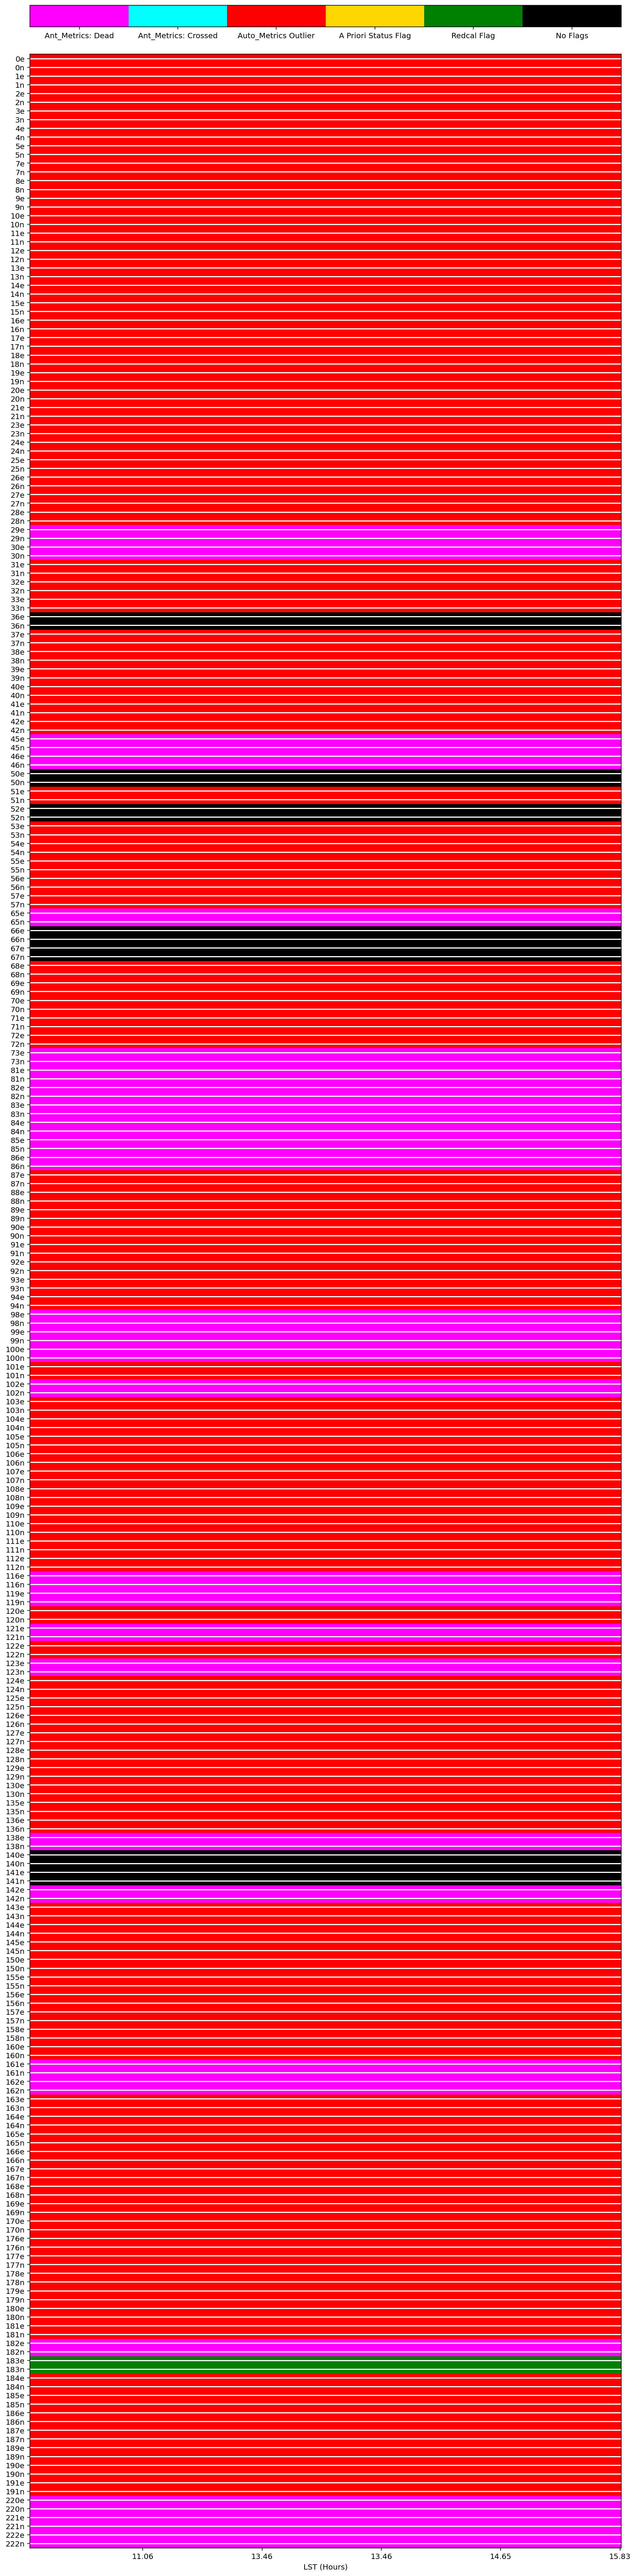

In [16]:
# Build up exants grid
#0 = AM dead, 1 =  AM crossed, 2 = auto_metrics, 3 = apriori, 4 = redcal, 5 = no flags 
exants_grid = np.zeros((len(ants),len(cal_list))) + 5.0

# if flagged for any reason, then it's at least a redcal flag
for f, cal in enumerate(ant_flags_dict):
    for i, ant in enumerate(ants):
        if ant_flags_dict[cal][ant]:
            exants_grid[i, f] = 4.0

# next a priori flag, but override if necessary
for f, df in enumerate(apriori_exants):
    for i, ant in enumerate(ants):
        if ant[0] in apriori_exants[df]:
            exants_grid[i, f] = 0.0

# next auto_metrics, but override with ant_metrics if also that
for f in range(len(ant_flags_dict)):
    for i, ant in enumerate(ants):
        if ant[0] in auto_ex_ants:
            exants_grid[i, f] = 2.0

# ant_metrics
for f, amf in enumerate(am_xants_dict):
    for i, ant in enumerate(ants):
        if ant in am_dead_ants_dict[amf]:
            exants_grid[i, f] = 0.0                
        elif ant in am_crossed_ants_dict[amf]:
            exants_grid[i, f] = 1.0

from mpl_toolkits.axes_grid1 import make_axes_locatable
color_order = ['magenta', 'cyan', 'red', 'gold', 'green', 'black']
cmap = matplotlib.colors.ListedColormap(color_order)
bounds=np.arange(len(color_order)+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            
fig = plt.figure(figsize=(14,len(ants)/4.625))
im = plt.imshow(exants_grid, aspect='auto', cmap=cmap, norm=norm, interpolation='nearest',
                extent=[times[0], times[-1], len(ants), 0])
plt.yticks(np.arange(len(ants))+.5, 
           labels = ['{}{}'.format(ant[0], ant[1][-1]) for ant in ants]);
plt.grid(color='w', linestyle='-', linewidth=1.5, axis='y')
plt.xlabel('LST (Hours)')
plt.gca().set_xticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                          for t in plt.gca().get_xticks()]] * 12 / np.pi, 2))

divider = make_axes_locatable(plt.gca())
cax = divider.new_vertical(size=.4, pad=0.5, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks(.5 + np.arange(len(color_order)))
cbar.set_ticklabels(['Ant_Metrics: Dead',
                     'Ant_Metrics: Crossed',
                     'Auto_Metrics Outlier',
                     'A Priori Status Flag', 
                     'Redcal Flag',
                     'No Flags', ])

### Figure 3: Antenna Flagging
Shows progressive stages of flagging. Note that "crossed" means relatively low power in Vxx and Vyy compared to Vxy and Vyx. This may be because the antenna is broken and all 4 pols have similar power levels, in which case it would still be an outlier according to this metric. 


#### OBSERVER CHECKLIST:
* Check for new antennas that went bad but weren't in the a priori list. If these are consistently flagged, mark the antenna as "calibration triage"

All-NaN slice encountered
FixedFormatter should only be used together with FixedLocator


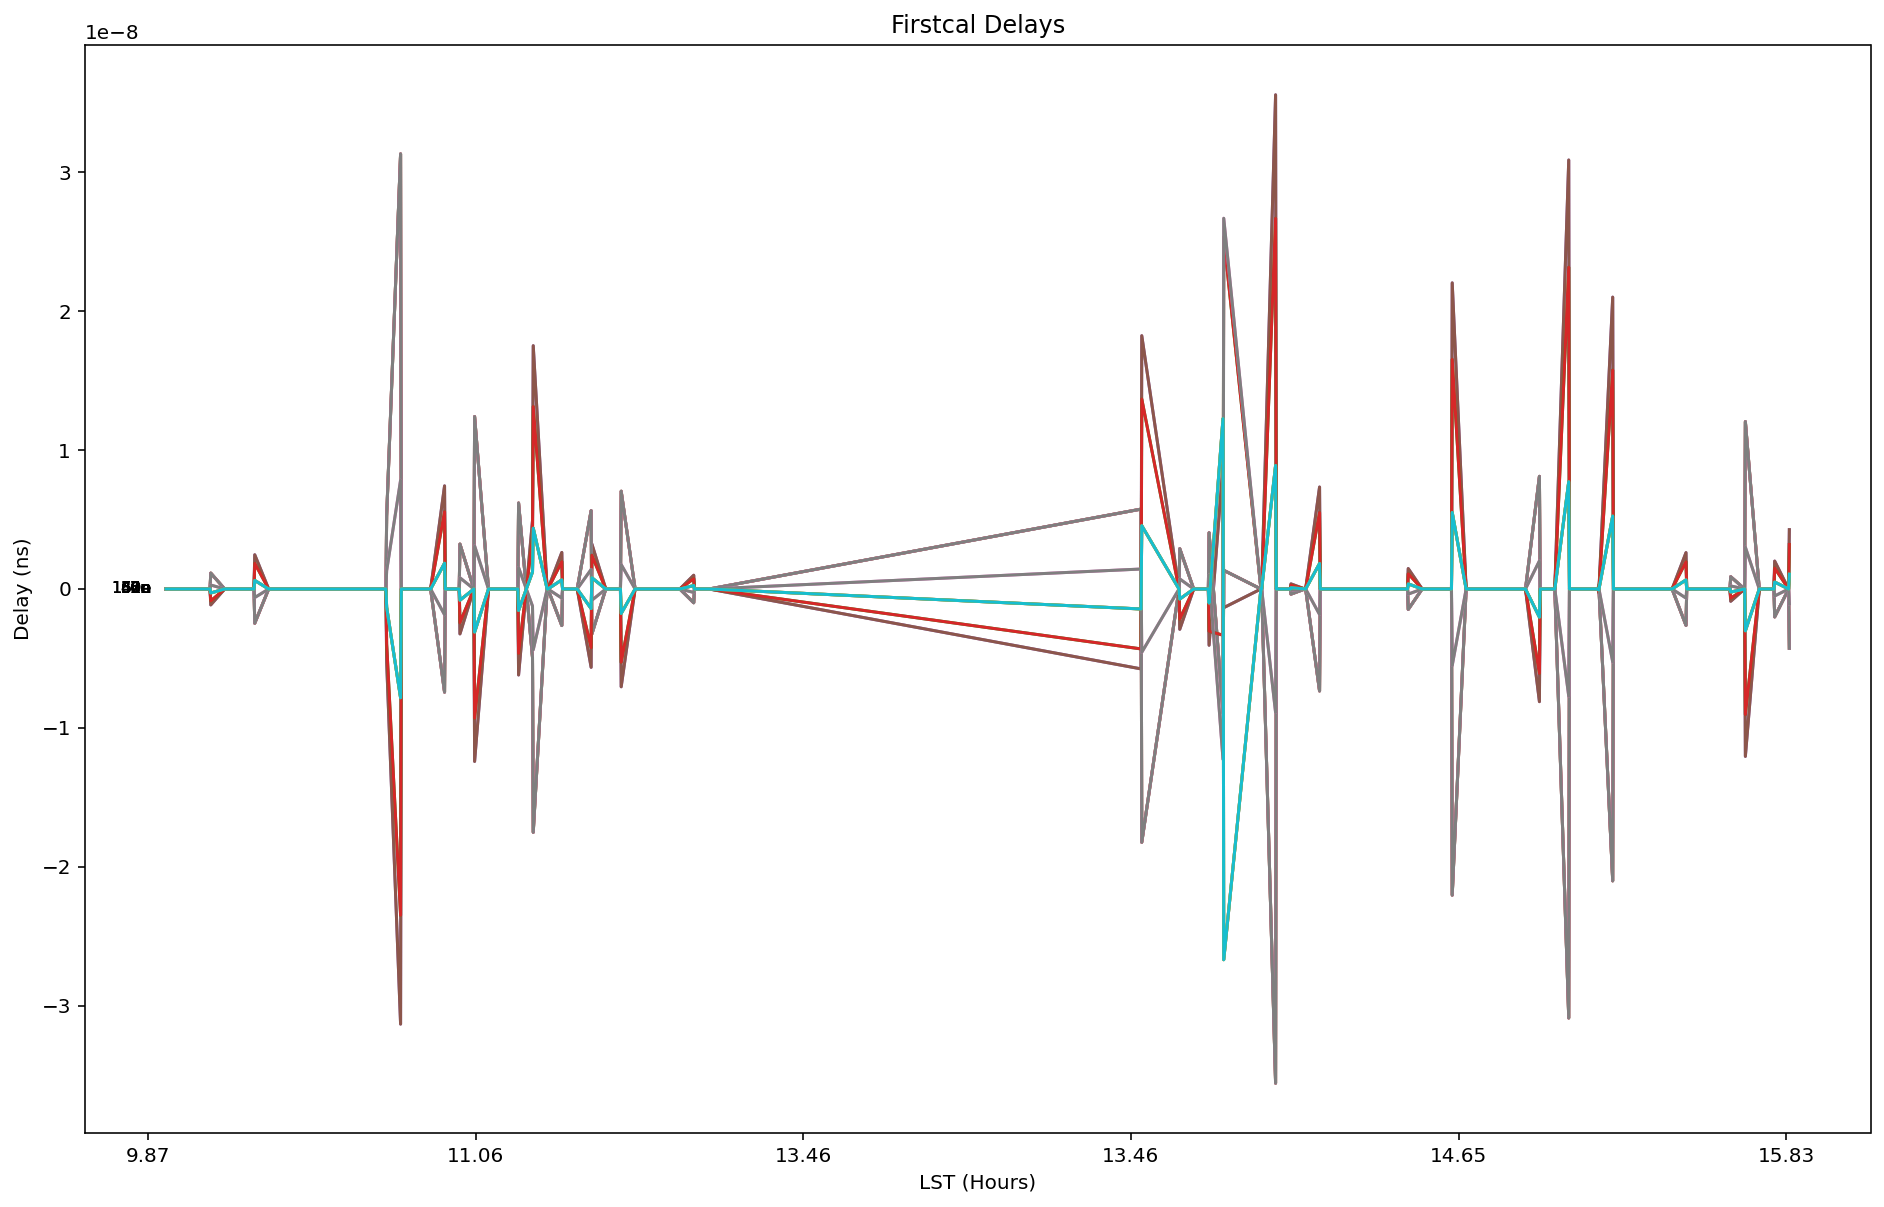

In [17]:
# Plot delays
dlys = {ant: np.hstack([dlys_dict[mf][ant] for mf in dlys_dict]) for ant in ants}
dly_meds = {ant: np.nanmedian(dlys[ant]) for ant in dlys}
plt.figure(figsize=(16,10))
for ant in dlys:
    plt.plot(times, (dlys[ant])*1e9)
    if np.isfinite(dly_meds[ant]):
        plt.text(np.min(times) - 20*np.median(np.diff(times)), 
                 1e9*dly_meds[ant], '{}{}'.format(ant[0], ant[1][-1]), 
                 va='center', ha='right', fontsize=8)    
plt.gca().set_xticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                          for t in plt.gca().get_xticks()]] * 12 / np.pi, 2))

plt.xlabel('LST (Hours)')
plt.ylabel('Delay (ns)')
plt.title('Firstcal Delays');

### Figure 4: Firstcal Delays
Shows solved firstcal delays. These will have an arbitrary tip/tilt and offset.


#### OBSERVER CHECKLIST:
* Look for outliers. All antennas should be within a few hundred ns. 

FixedFormatter should only be used together with FixedLocator


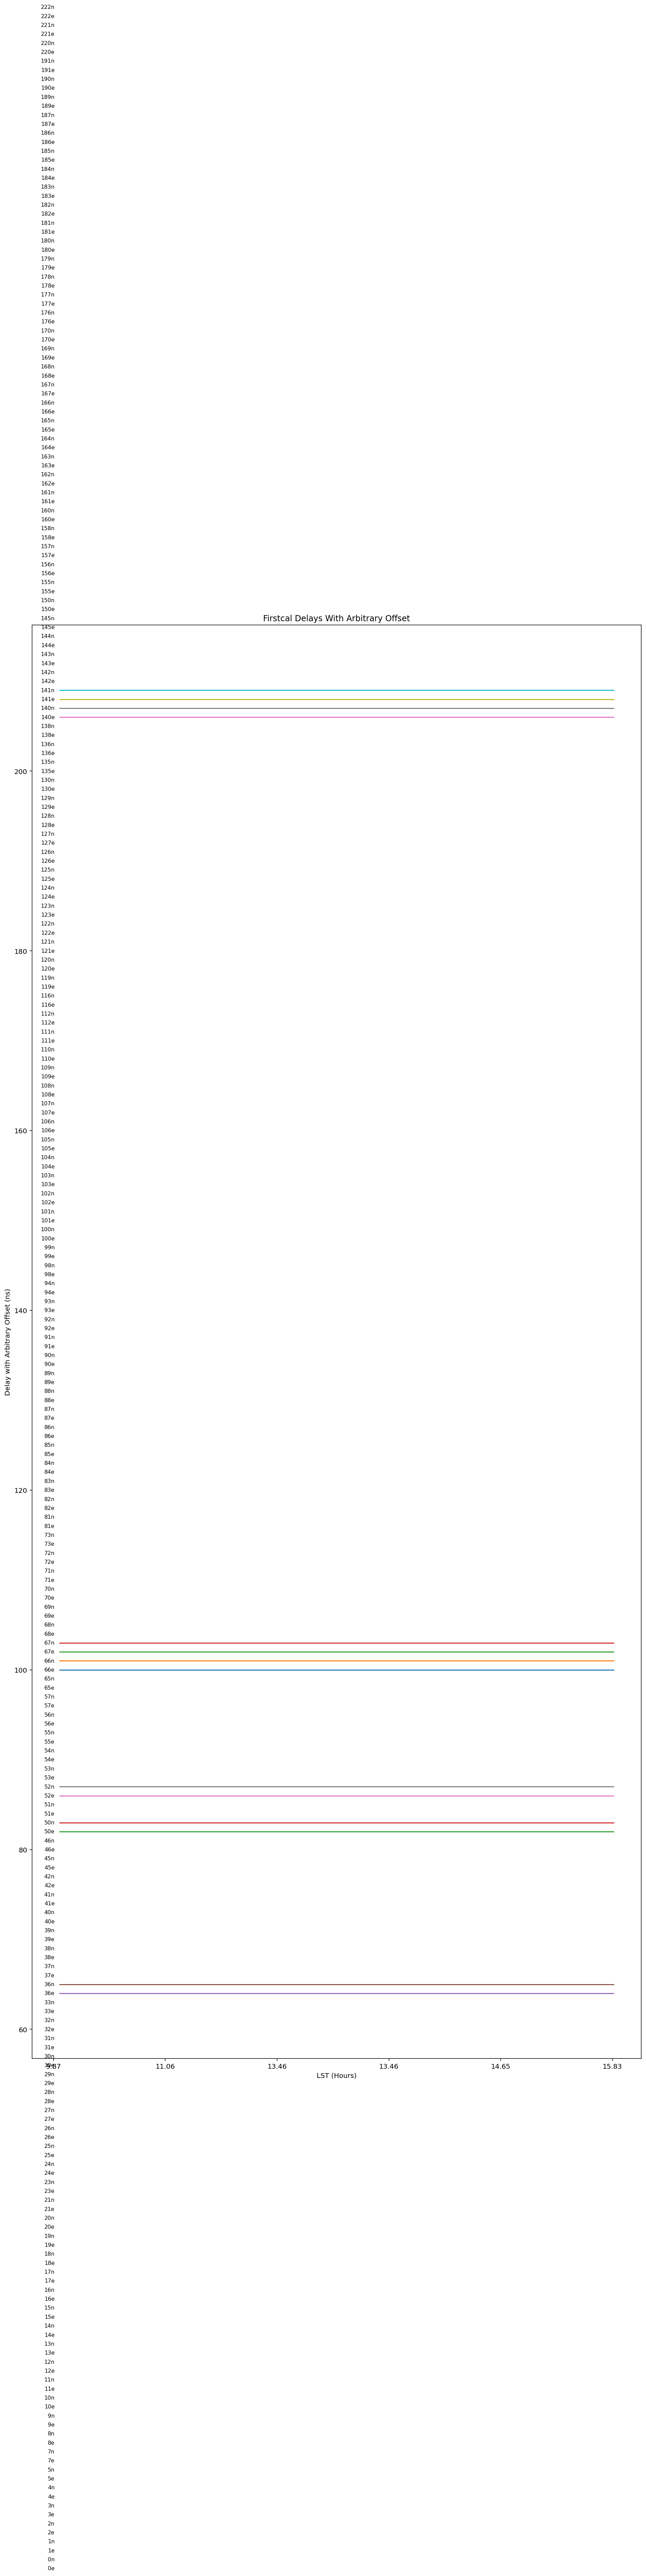

In [18]:
# Plot offset delays
plt.figure(figsize=(16, len(ants)/7.4))
for n, ant in enumerate(dlys):
    plt.plot(times, (dlys[ant]-dly_meds[ant])*1e9 + n, label=ant)
    plt.text(np.min(times) - 20*np.median(np.diff(times)), 
             n, '{}{}'.format(ant[0], ant[1][-1]), 
             va='center', ha='right', fontsize=8)
plt.gca().set_xticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                          for t in plt.gca().get_xticks()]] * 12 / np.pi, 2))
plt.xlabel('LST (Hours)')
plt.ylabel('Delay with Arbitrary Offset (ns)')
plt.title('Firstcal Delays With Arbitrary Offset');

### Figure 5: Offset Firstcal Delays
Same as Figure 4, but with arbitrary offsets for each antenna.


#### OBSERVER CHECKLIST:
* Look for antennas that exhibit wild swings (> 10 ns) in their delay over time, especially discontinuities that cannot be attributed to inconsistent antenna flagging (see Figure 3).

In [19]:
# Figure out oc_maxiter
if np.all(['oc_maxiter' in history for history in histories_dict.values()]):
    history = list(histories_dict.values())[0]
    oc_maxiter = int(history.split('--oc_maxiter')[1].split('--')[0])
else:
    oc_maxiter = inspect.signature(redcal.redcal_run).parameters['oc_maxiter'].default

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
FixedFormatter should only be used together with FixedLocator


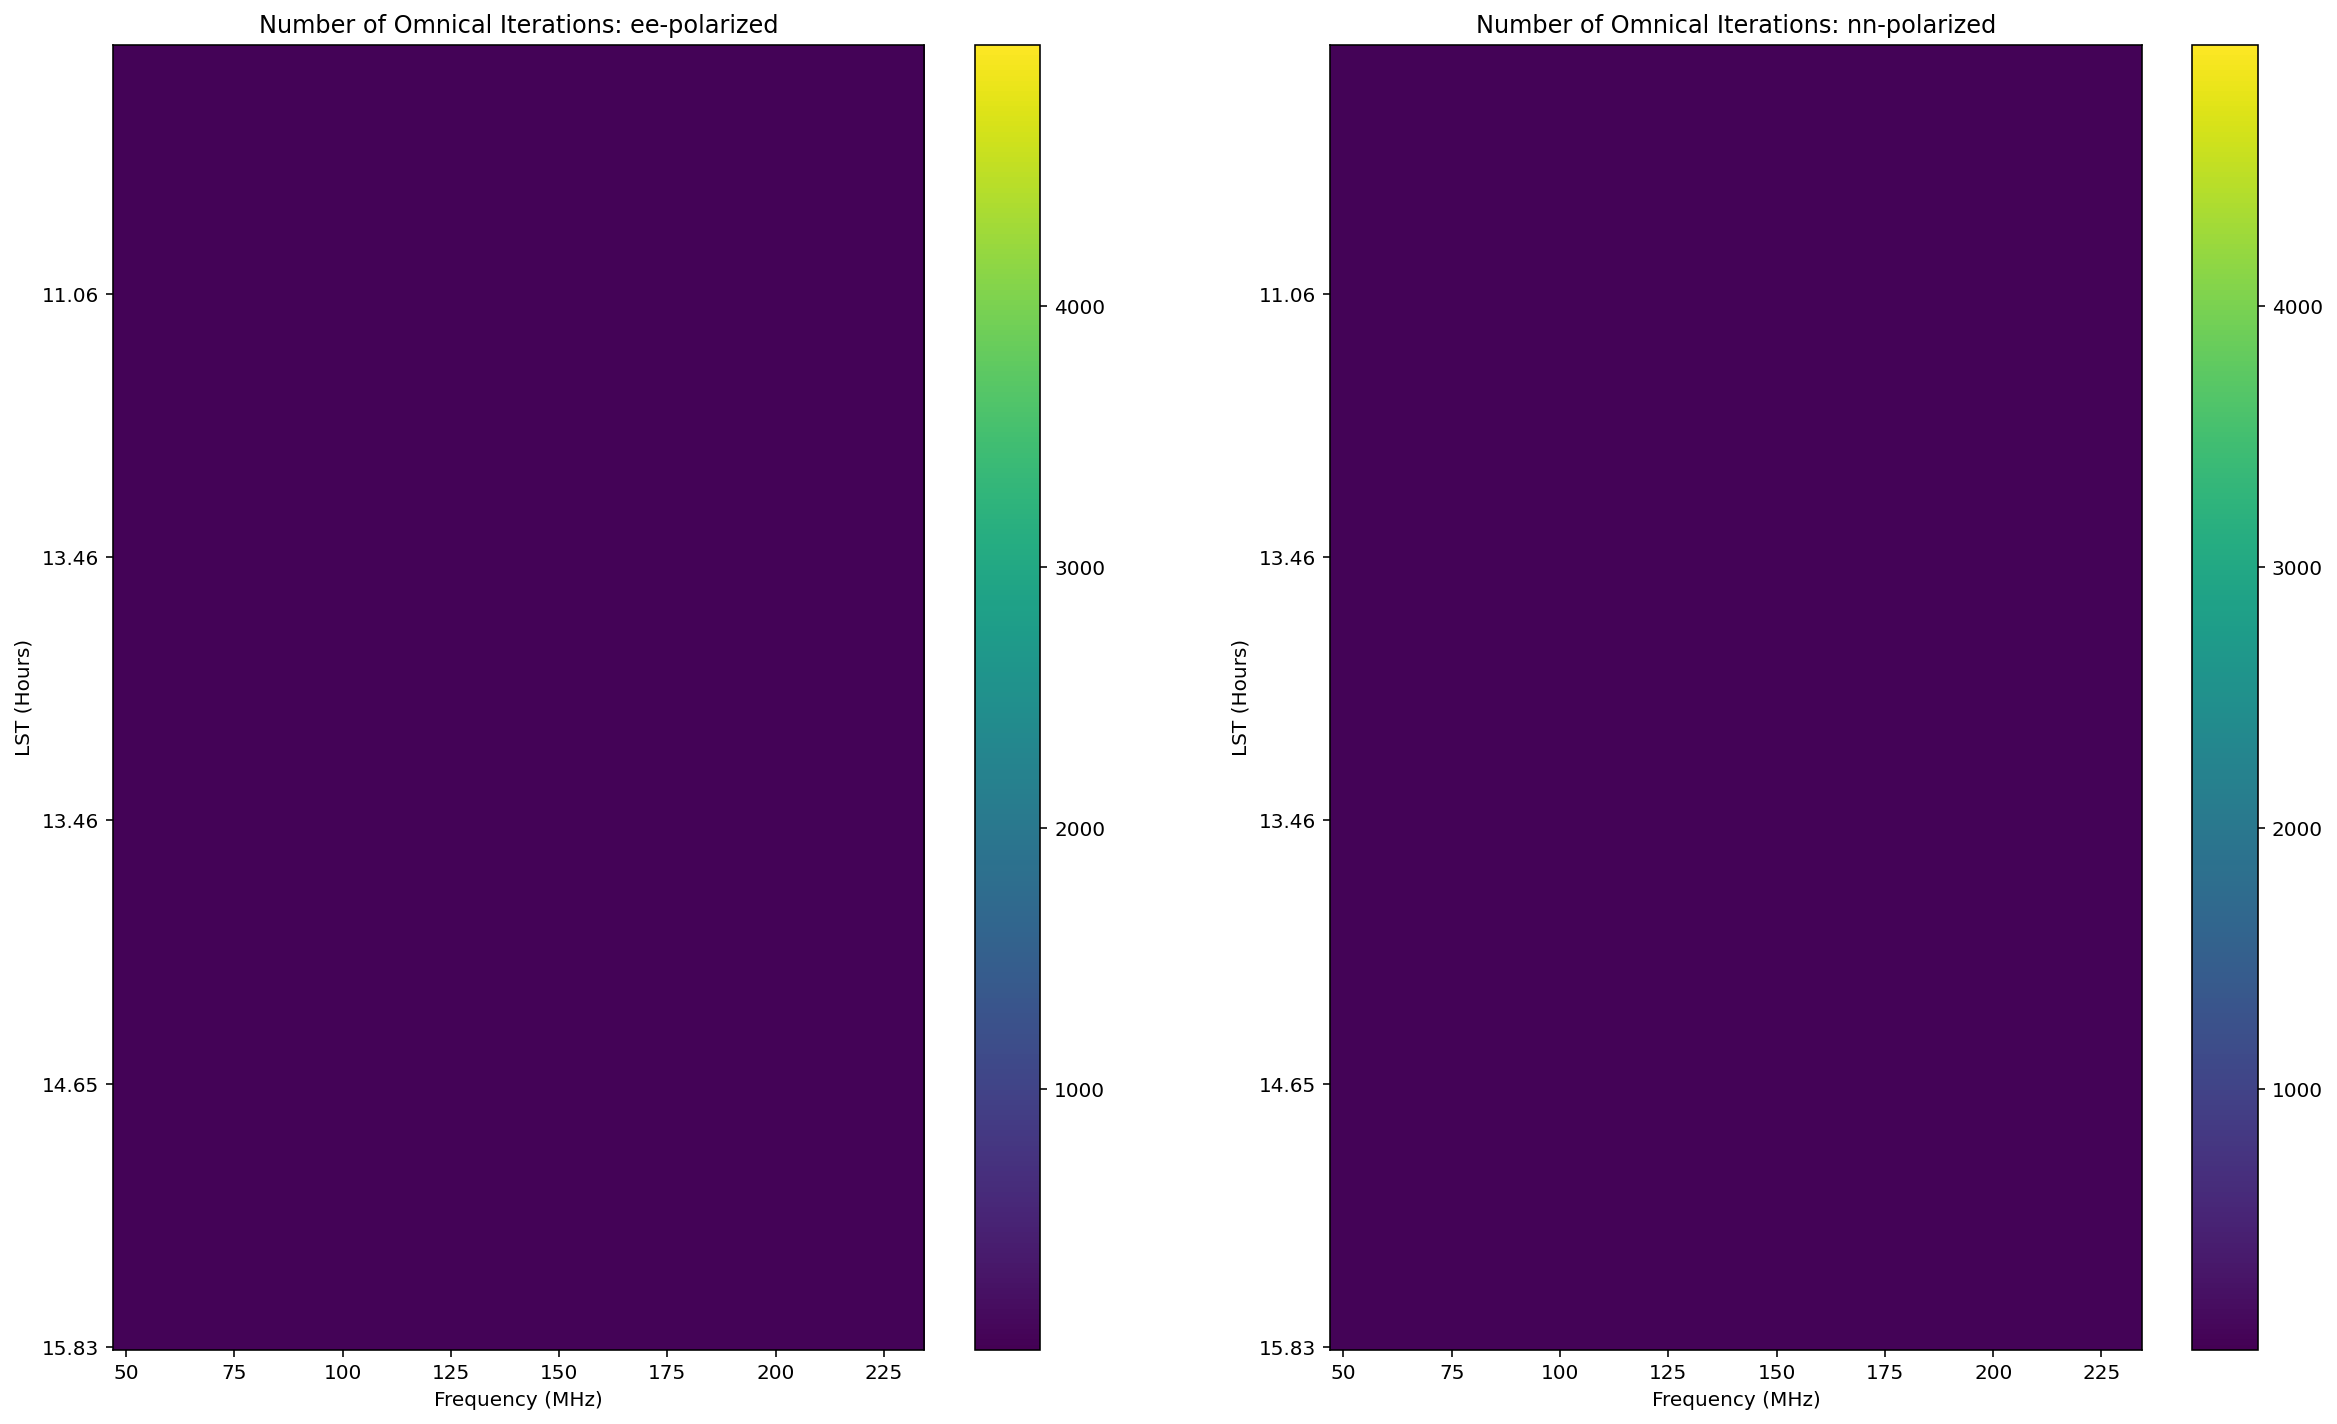

In [20]:
# Recast from dictionaries to one big array
ee_iters = np.vstack(np.array(list(ee_iters_dict.values())))
nn_iters = np.vstack(np.array(list(nn_iters_dict.values())))
plt.figure(figsize=(20,12))

my_cmap = deepcopy(matplotlib.cm.get_cmap('viridis'))
my_cmap.set_under('w')
my_cmap.set_over('r')

for sp, iters, t in zip([121, 122], [ee_iters, nn_iters], 
                        ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    plt.imshow(iters, aspect='auto', cmap=my_cmap, vmin=1, vmax=oc_maxiter-1, interpolation='nearest',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, times[-1], times[0]])
    plt.title('Number of Omnical Iterations: ' + t)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')    
    plt.gca().set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                              for t in plt.gca().get_yticks()]] * 12 / np.pi, 2))    
    plt.colorbar()

### Figure 6: Number of omnical iterations per polarization
Red indicates that omnical reached the maximum number of integrations. White indicates that omnical didn't run, likely because the data were flagged.


#### OBSERVER CHECKLIST:
* Check that few-to-no data were flagged (white) before omnical and check that this matches
* Check that few-to-no data hit the maximum number of iterations for omnical (red)

Mean of empty slice


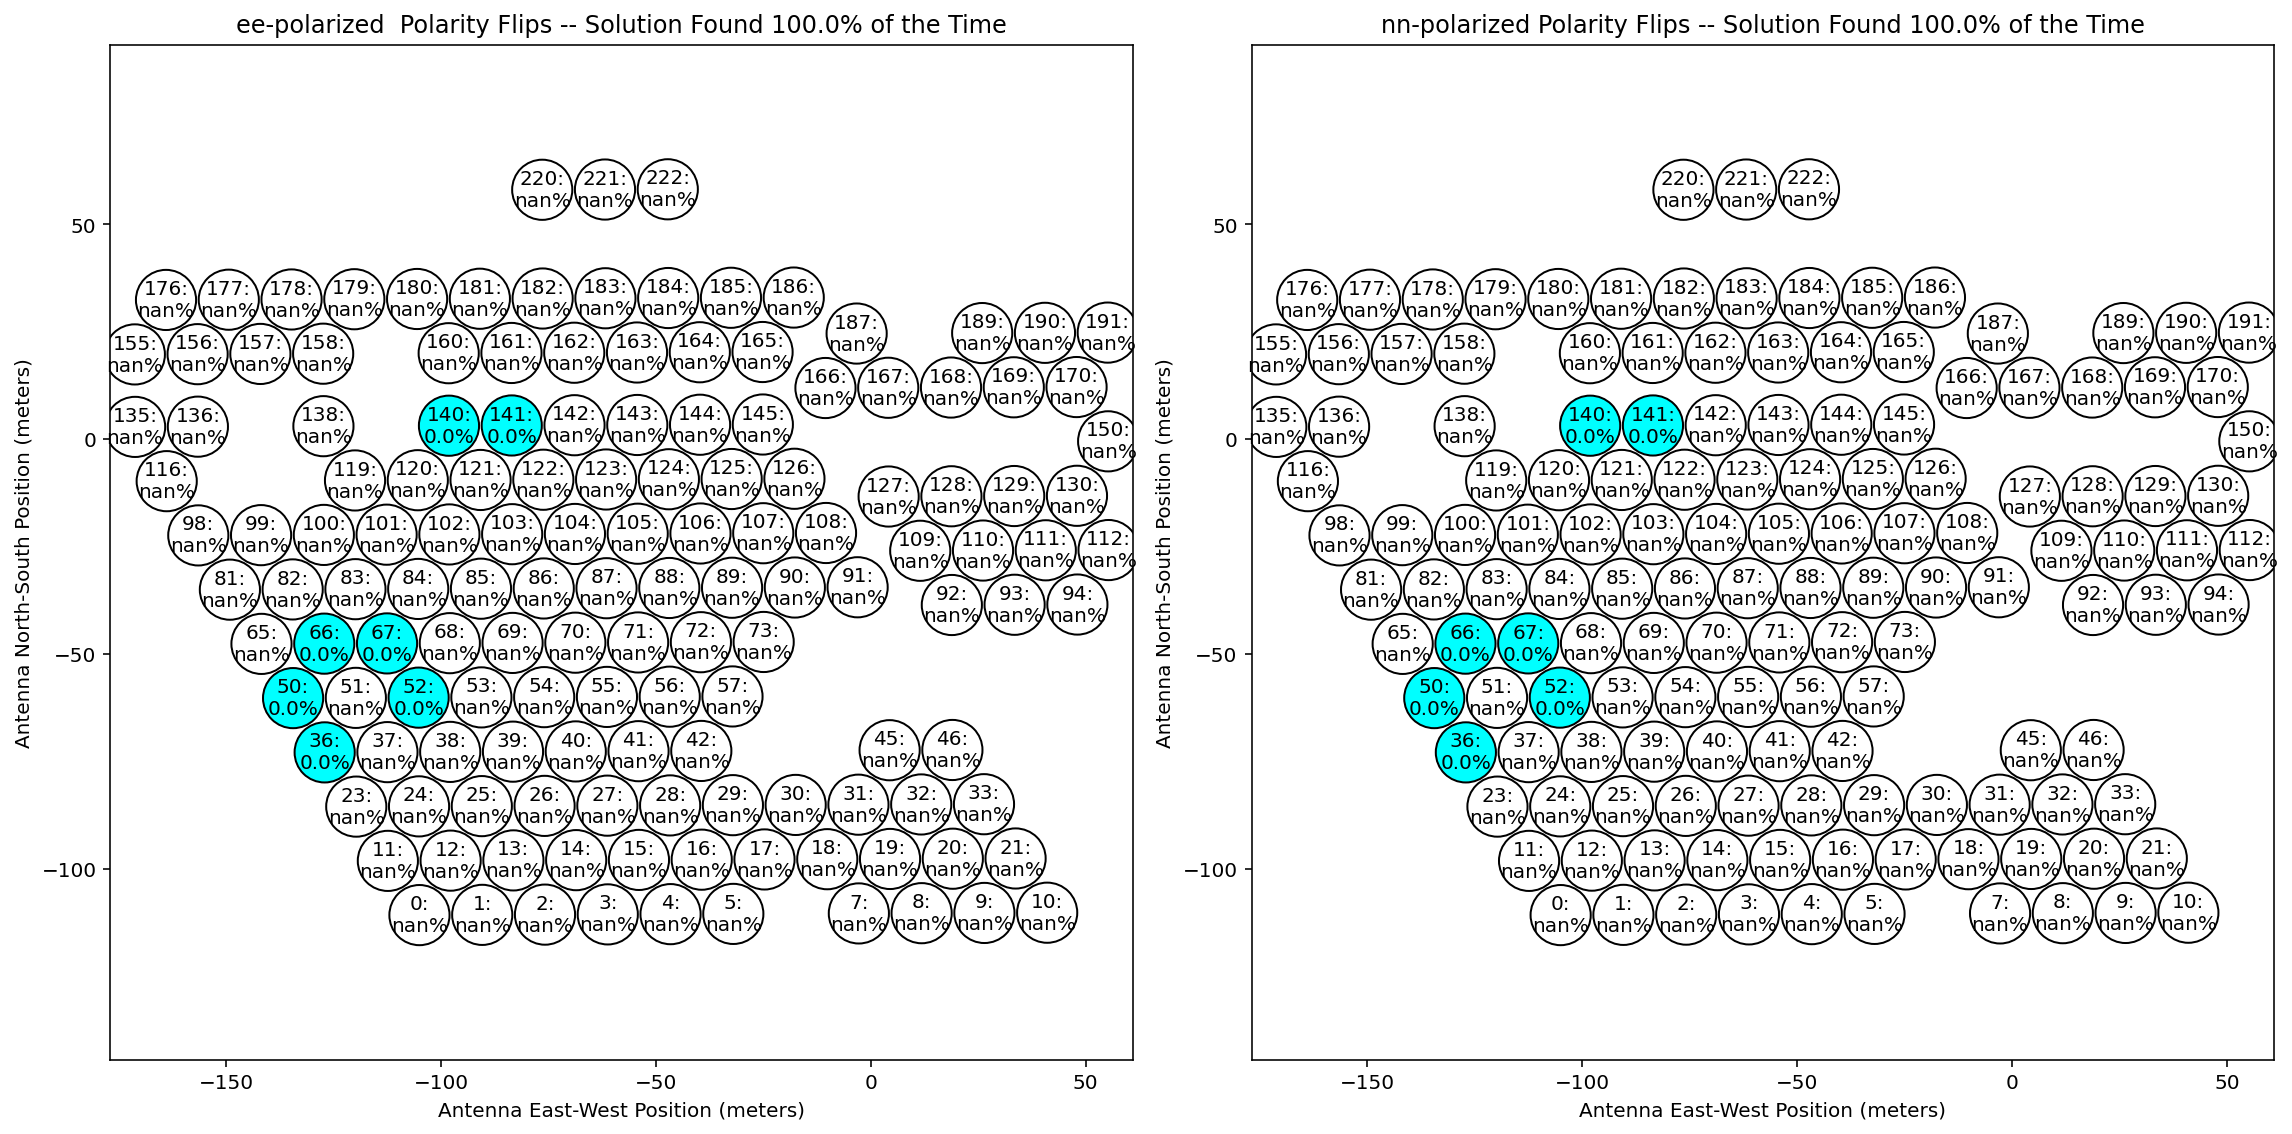

In [21]:
# Make dictionary mapping antenna to the whole night of antenna flips
flips = {ant: np.hstack([flips_dict[mf][ant] for mf in flips_dict]) for ant in ants}

plt.figure(figsize=(16,8))
my_cmap = matplotlib.cm.get_cmap('cool')
for sp, jpol, t in zip([121, 122], ['Jee', 'Jnn'], ['ee-polarized ', 'nn-polarized']):
    plt.subplot(sp)
    plt.scatter(np.array(list(hd.data_antpos.values()))[:,0], 
                np.array(list(hd.data_antpos.values()))[:,1],
                c='w', s=0)
    for ant,pos in hd.data_antpos.items():
        flip_frac = np.nanmean(flips[(ant, jpol)])
        if np.isfinite(flip_frac):
            color=my_cmap(flip_frac)
        else:
            color='w'
        plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                        fill=(~bad), color=color, ec='k'))
        plt.text(pos[0], pos[1],
                 '{}:\n{}%'.format(ant, np.round(100*flip_frac,0)), 
                 va='center', ha='center', color='k')
    plt.xlabel("Antenna East-West Position (meters)")
    plt.ylabel("Antenna North-South Position (meters)")
    
    # count the number of times a self-consistent polarity flip solution was found
    all_flips_this_pol = [flips[ant] for ant in flips if ant[1] == jpol]
    success = np.round(100*np.mean(np.any(np.isfinite(all_flips_this_pol), axis=0)), 2)
    plt.title(t + ' Polarity Flips -- Solution Found {}% of the Time'.format(success))
    plt.axis('equal')
    plt.tight_layout()

### Figure 7: Detection of polarity-flipped antennas
Blue indicates nominal operation, pink indicates polarity flips. 


#### OBSERVER CHECKLIST:
* Check that all antennas are either nearly 100% flipped, nearly 0% flipped, or flagged.
* Check that a solution for polarity flips was found a reasonable percentage of the time (ideally more than a few %)

FixedFormatter should only be used together with FixedLocator


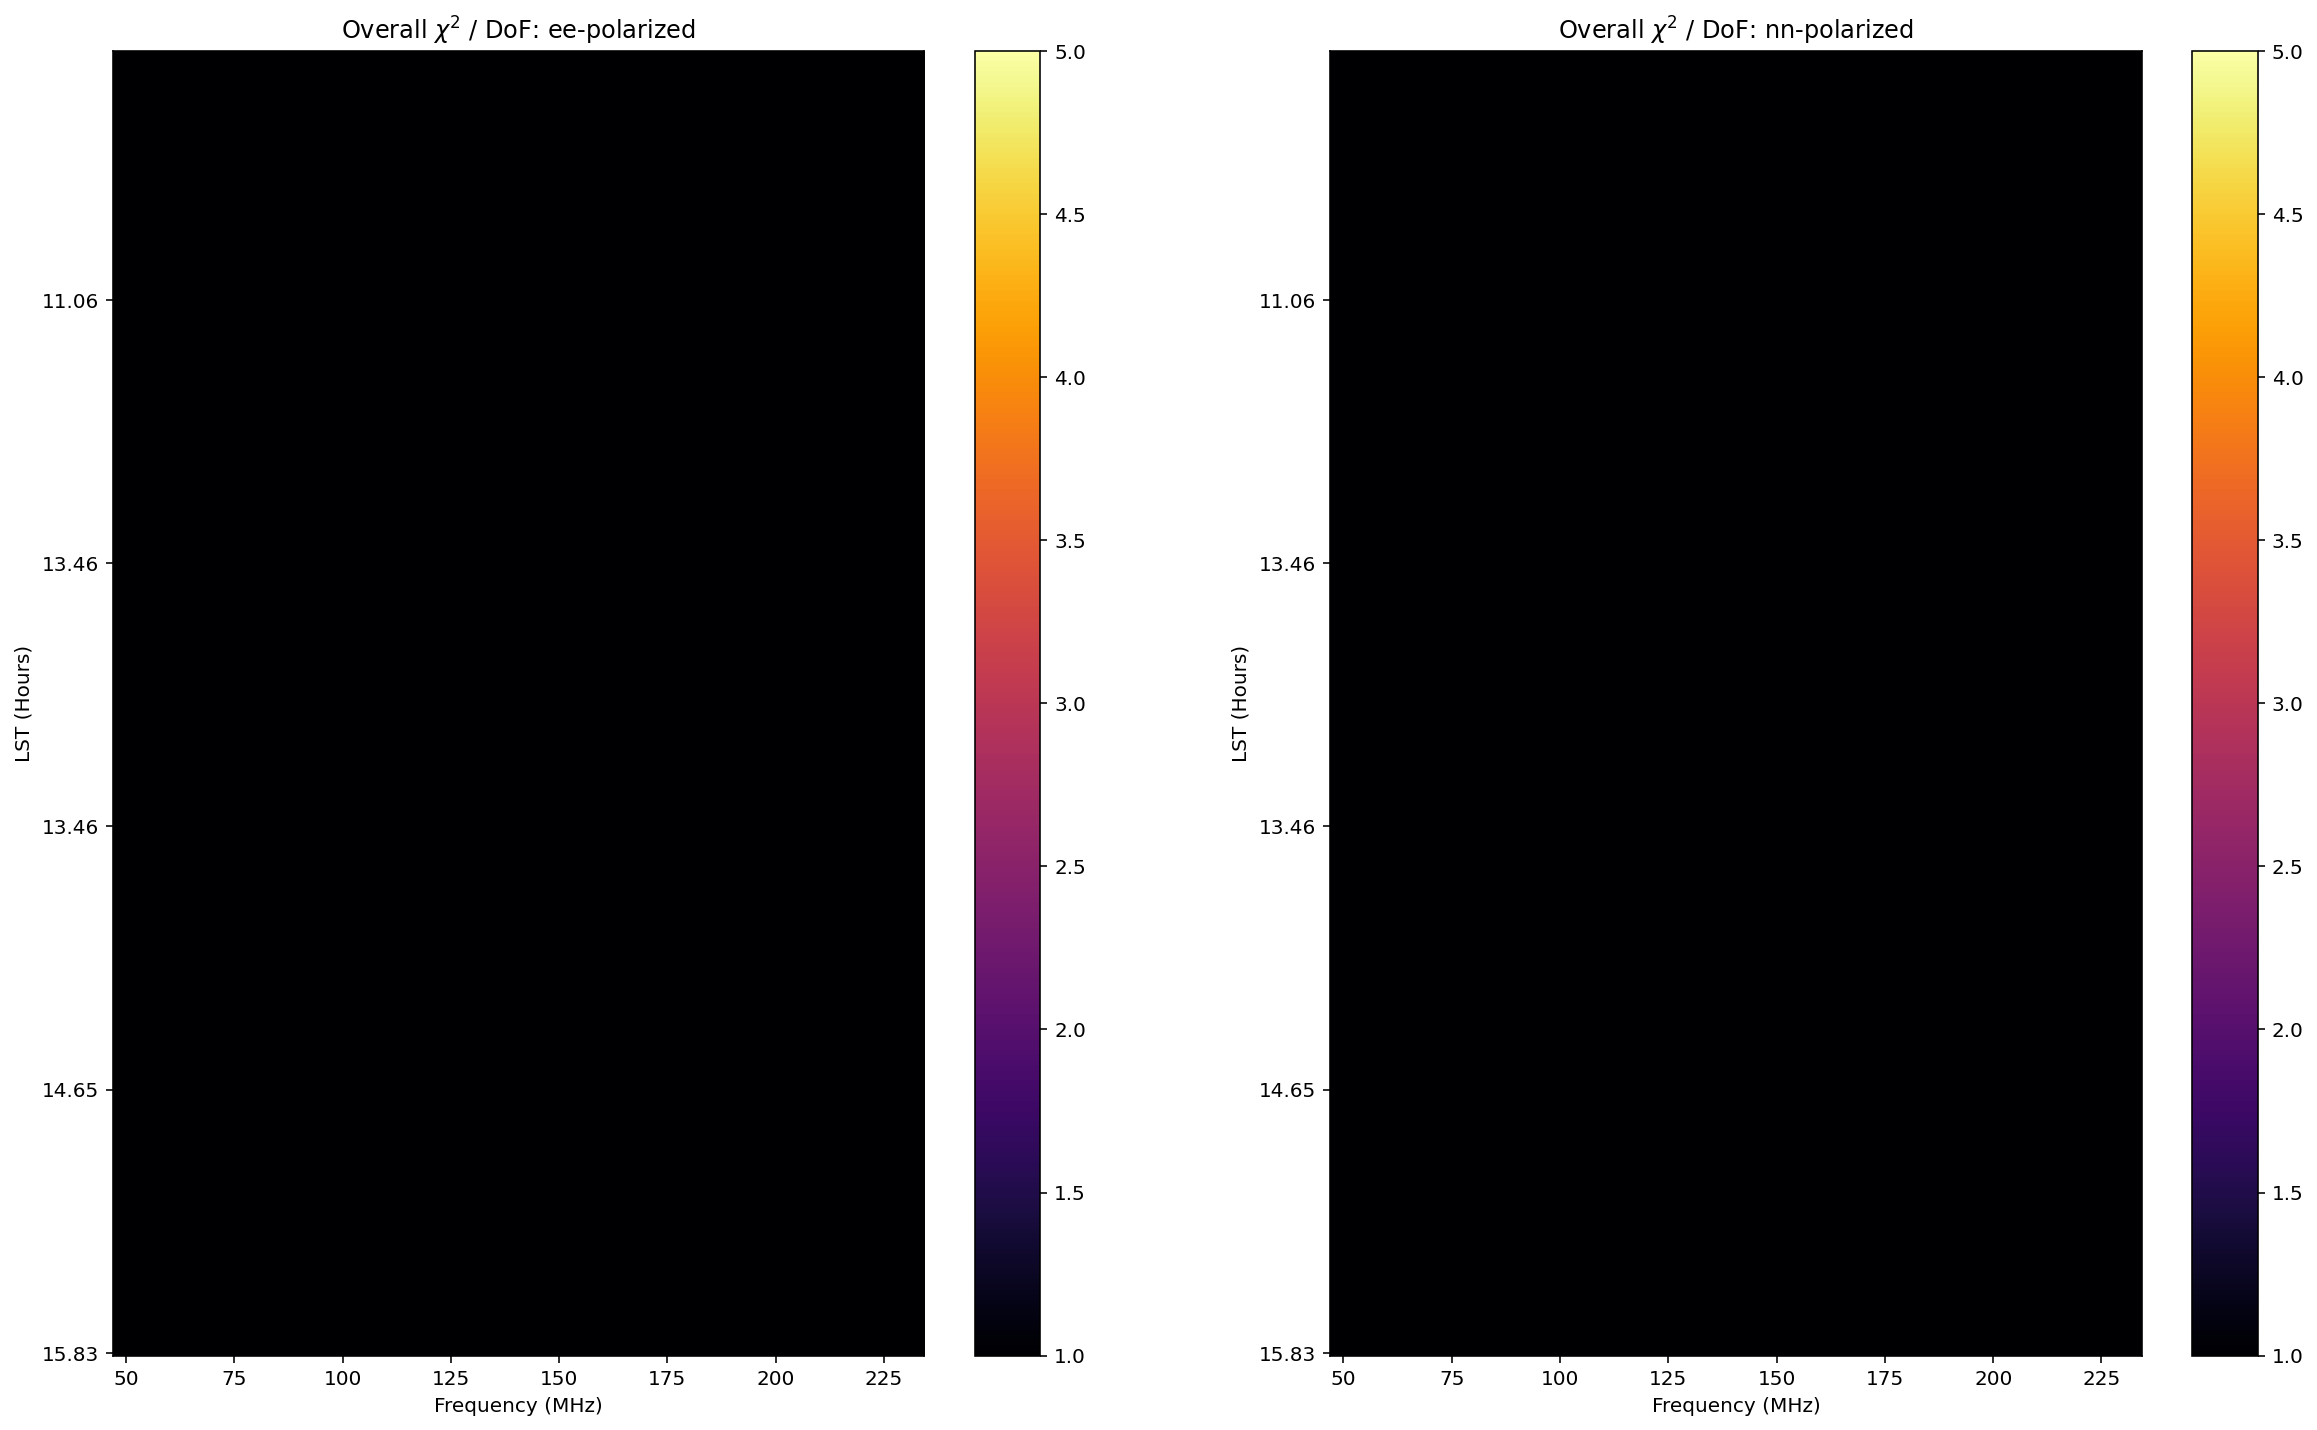

In [22]:
# Grid and plot overall chi^2 for each polarization
ee_chisq = np.vstack(np.array(list(chisq_ee_dict.values())))
nn_chisq = np.vstack(np.array(list(chisq_nn_dict.values())))
plt.figure(figsize=(20,12))

for sp, cs, t in zip([121, 122], [ee_chisq, nn_chisq], ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    plt.imshow(cs, aspect='auto', vmin=1, cmap='inferno', vmax=5, interpolation='nearest',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, times[-1], times[0]])
    plt.title('Overall $\chi^2$ / DoF: ' + t)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')        
    plt.gca().set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                          for t in plt.gca().get_yticks()]] * 12 / np.pi, 2))
    plt.colorbar()
    

### Figure 8: Overall $\chi^2$ / DoF


#### OBSERVER CHECKLIST:
* Looks for regions of large non-redundancy not directly attributable to RFI.

FixedFormatter should only be used together with FixedLocator
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
FixedFormatter should only be used together with FixedLocator
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


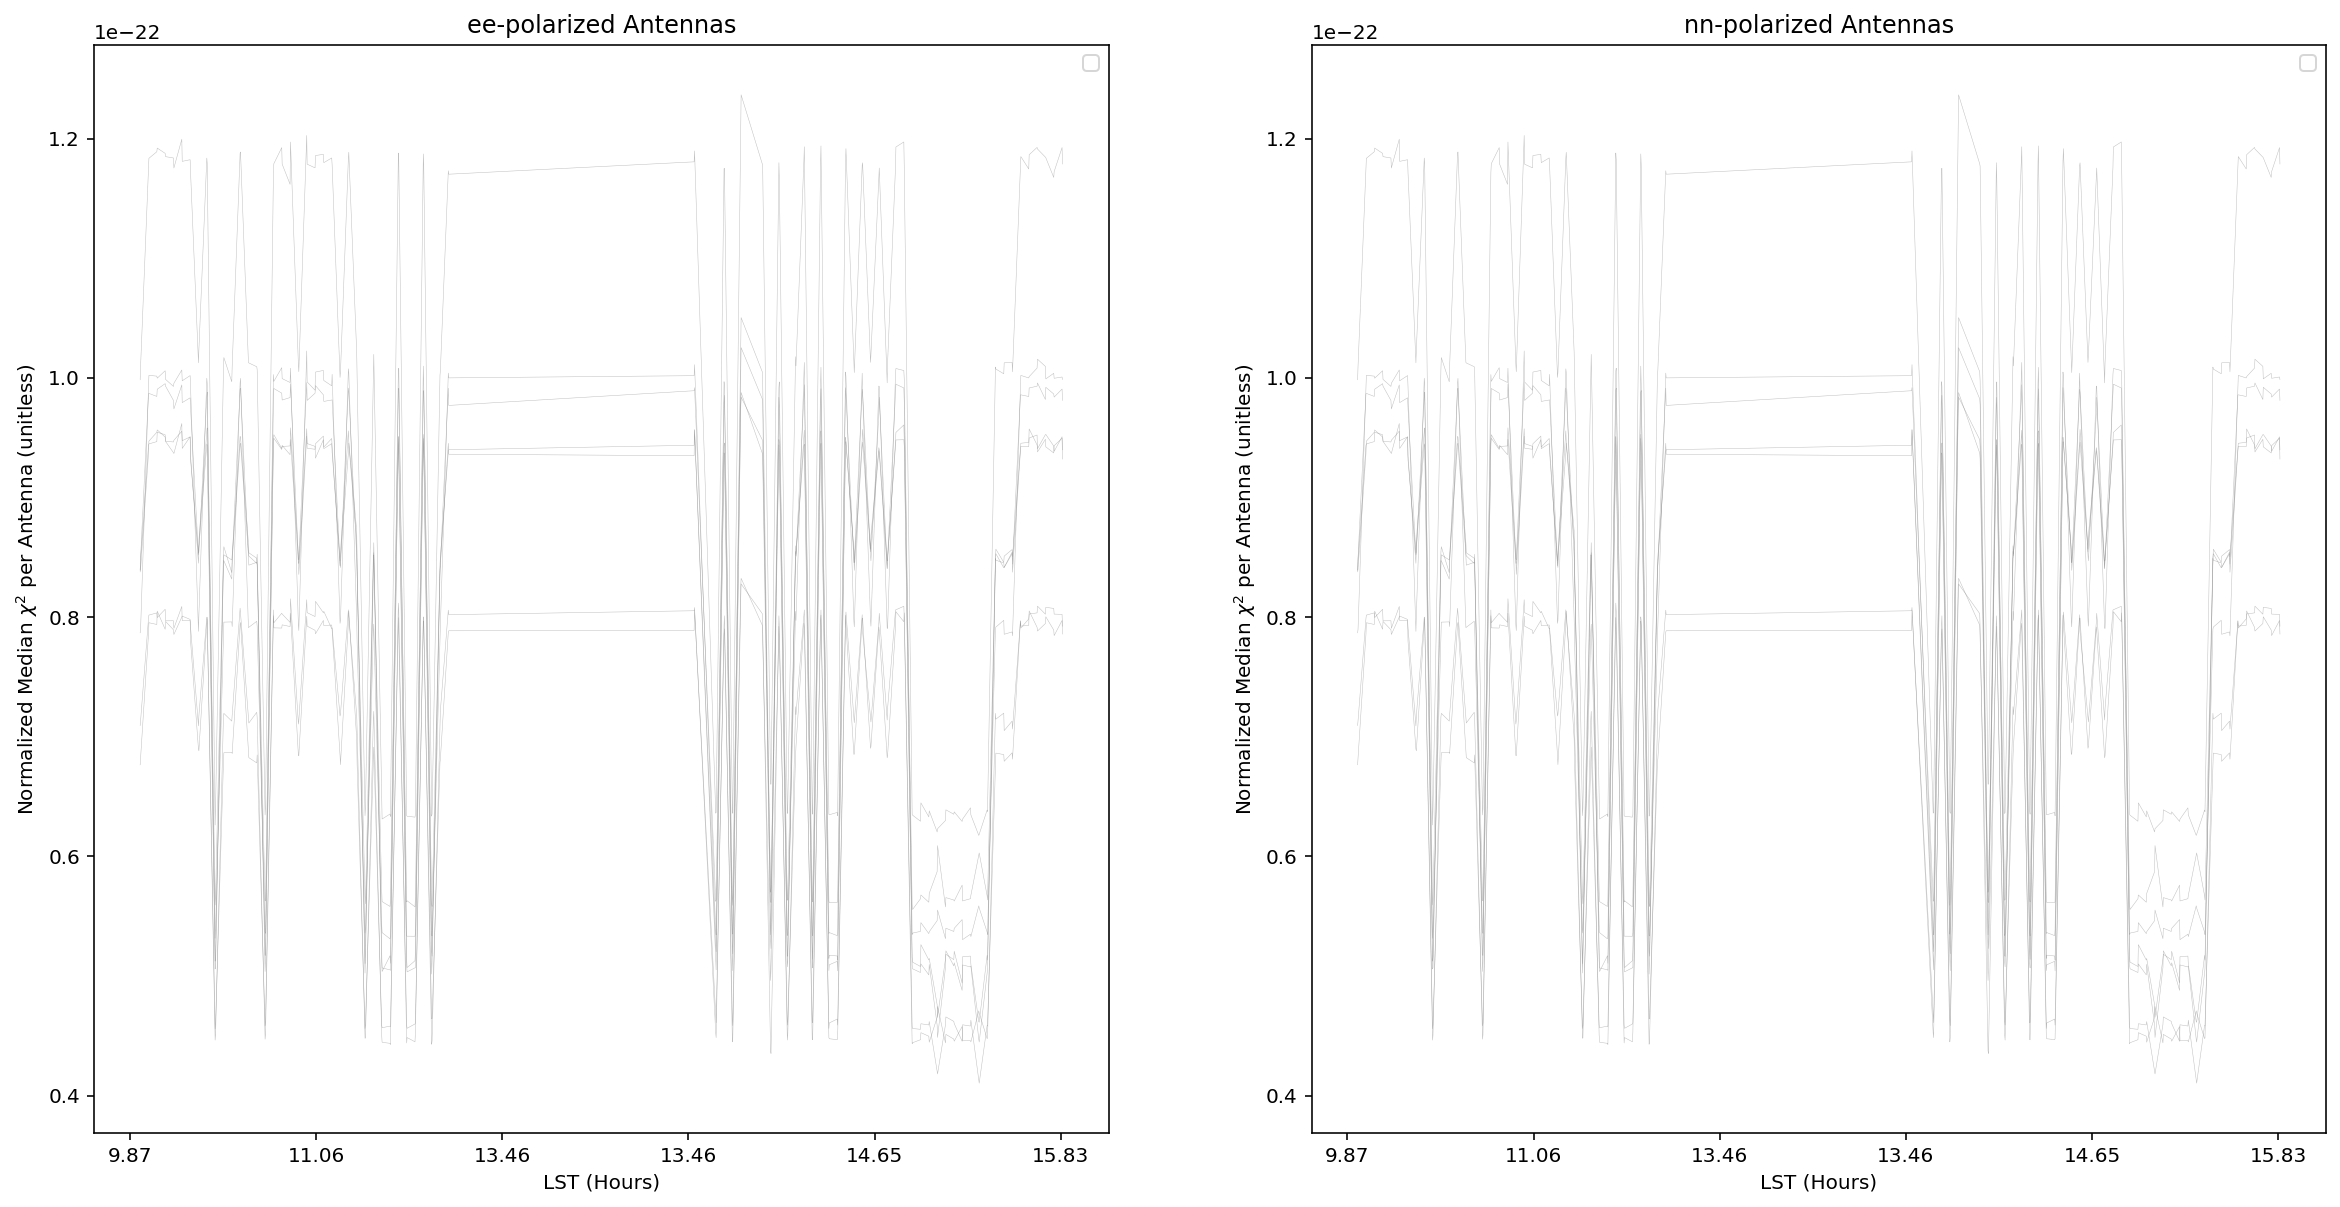

In [23]:
# plot all chi^2 per antenna, highlight antennas that get flagged but not always
plt.figure(figsize=(20,10))
for sp, pol, t in zip([121, 122], ['Jee', 'Jnn'], ['ee-polarized', 'nn-polarized']):
    plt.subplot(sp)
    for ant in ants:
        if ant[1] == pol:
            if not np.all([ant_flags_dict[cal][ant] for cal in cal_list]):
                if np.any([ant_flags_dict[cal][ant] and 
                           not np.all(list(ant_flags_dict[cal].values())) 
                           for cal in cal_list]):
                    plt.plot(times, cspa[ant], '.', label=ant)
                else:
                    plt.plot(times, cspa[ant], '-', c='grey', alpha=.5, lw=.25)
    plt.ylabel('Normalized Median $\chi^2$ per Antenna (unitless)')
    plt.xlabel('LST (Hours)')
    plt.gca().set_xticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                              for t in plt.gca().get_xticks()]] * 12 / np.pi, 2))    
    plt.title(t + ' Antennas')
    plt.legend()

### Figure 9: Normalized $\chi^2$ per antenna
Only unflagged data is shown, but antennas that were ever flagged are colored and shown in the legend. All other antennas are shown in grey.

#### OBSERVER CHECKLIST:
* Look for outliers in the chi^2 per antenna distribution
* Look for evidence that antenna that was sometimes flagged should have been always flagged. 

FixedFormatter should only be used together with FixedLocator


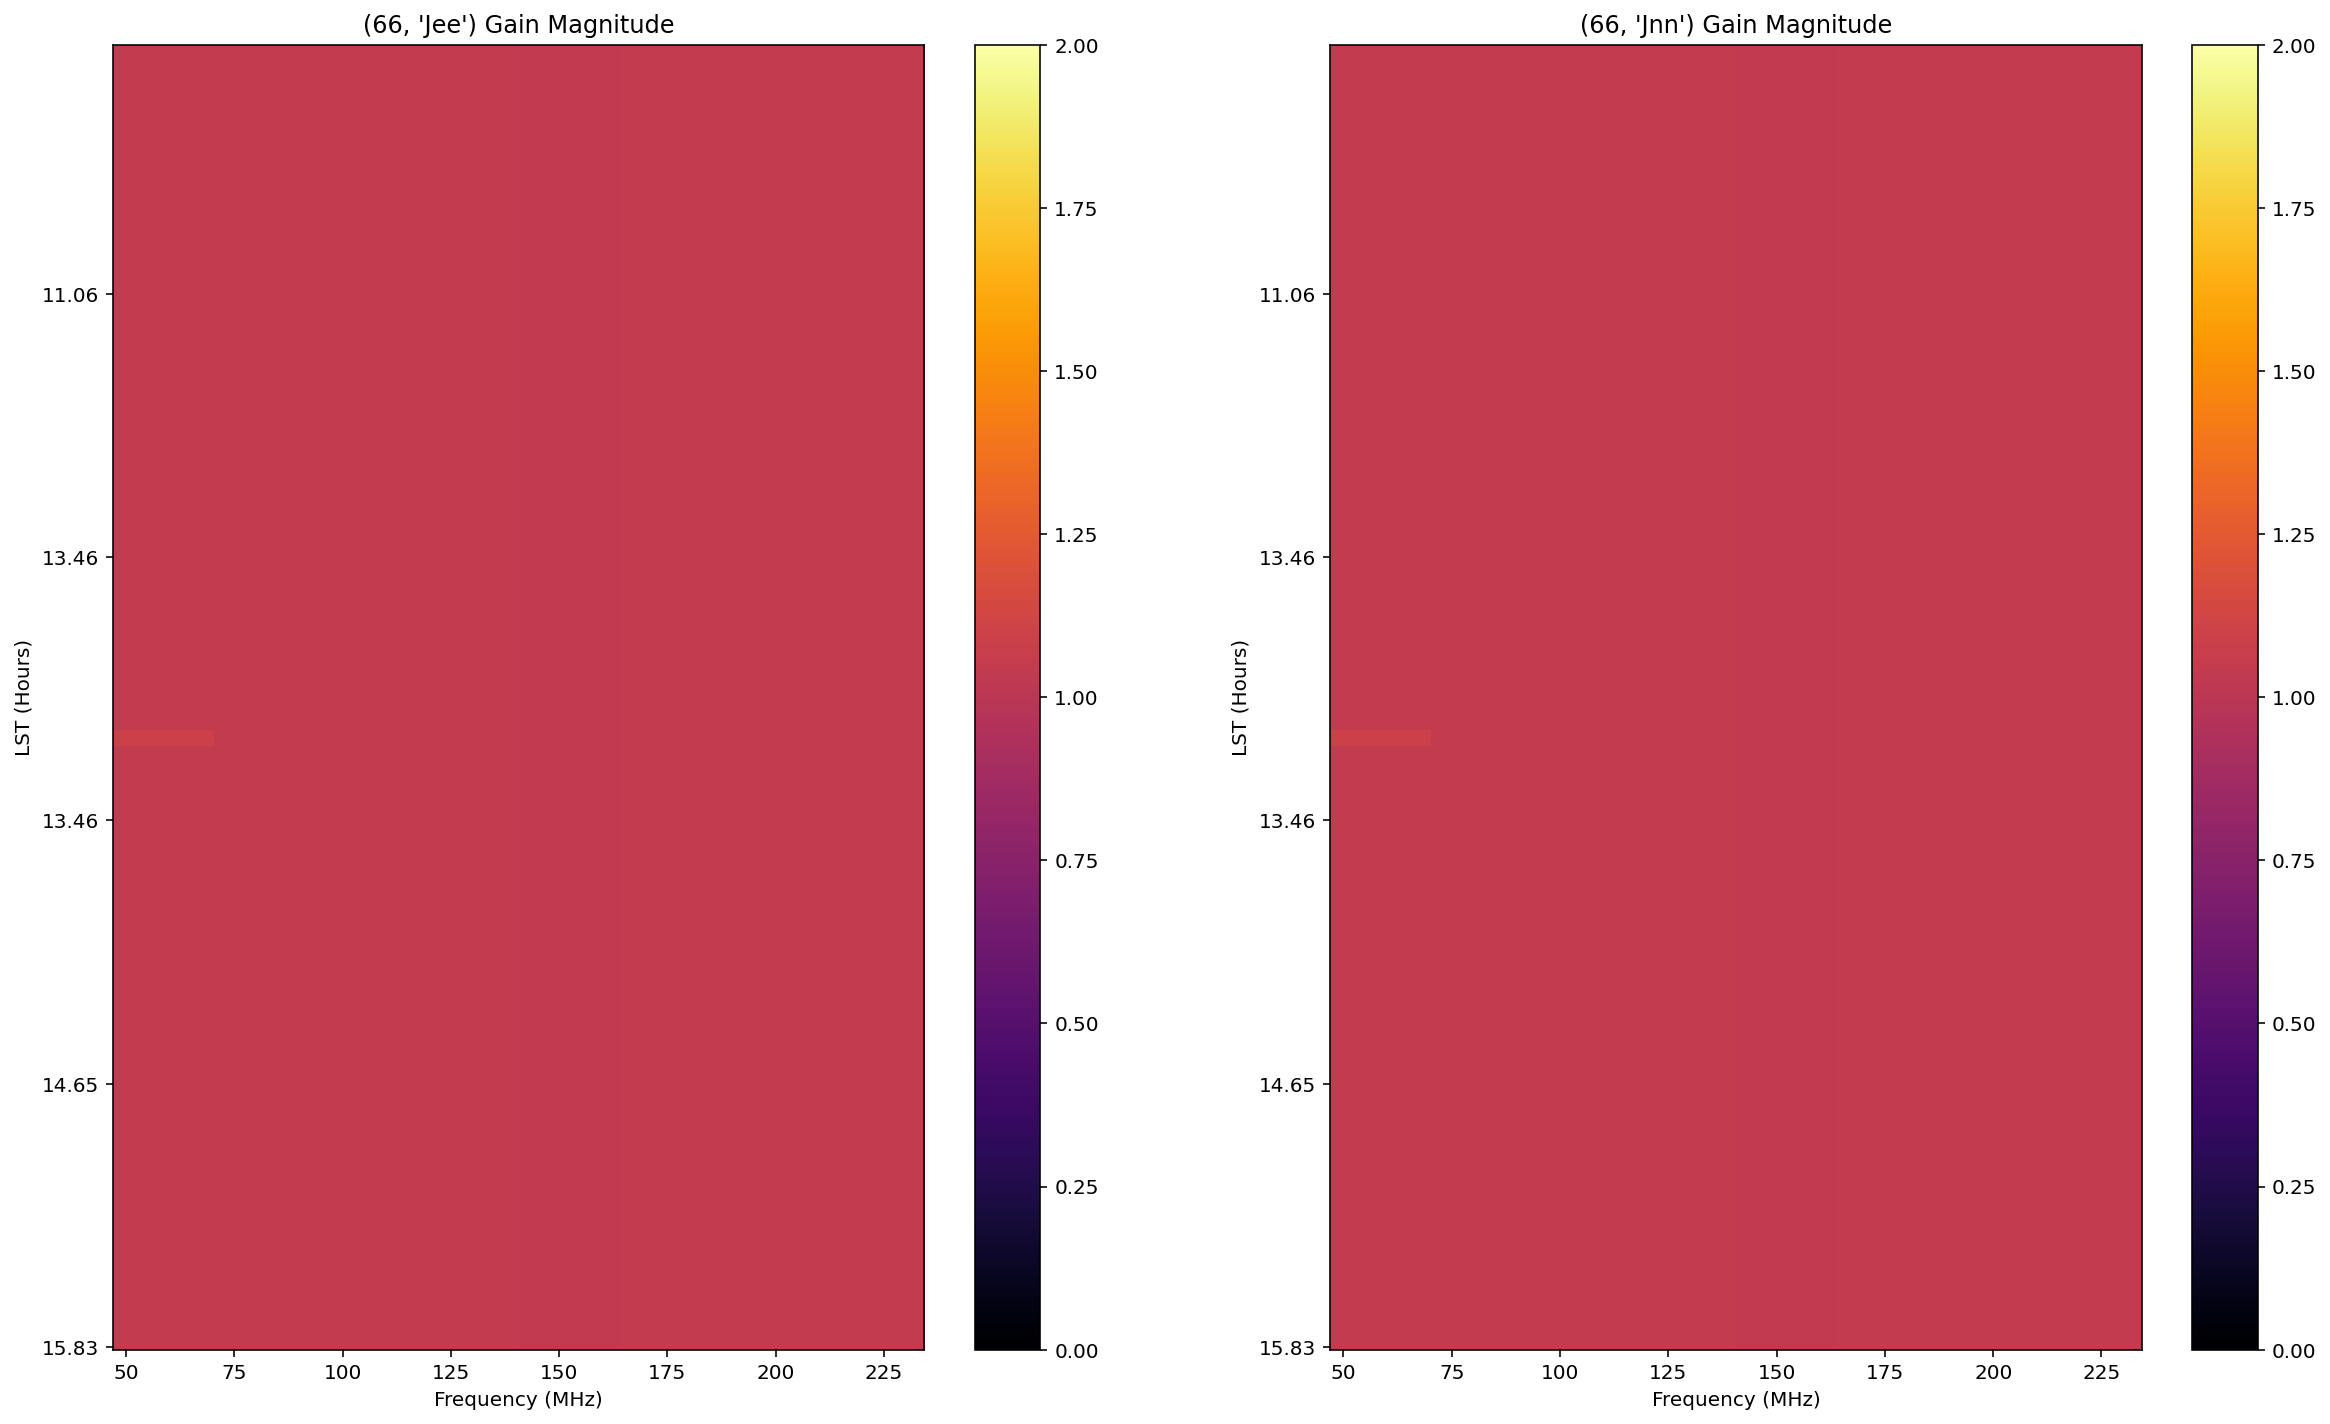

In [24]:
# Plot example gain amplitudes
plt.figure(figsize=(20,12))
for sp, pol in zip([121, 122], ['Jee', 'Jnn']):
    plt.subplot(sp)
    ant = ants_to_save[pol][1]
    plt.title(str(ant) + ' Gain Magnitude')
    plt.imshow(np.abs(gains[ant]), aspect='auto', cmap='inferno', interpolation='nearest',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, times[-1], times[0]])
    plt.clim([0,2])
    plt.colorbar()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')    
    plt.gca().set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                              for t in plt.gca().get_yticks()]] * 12 / np.pi, 2))    

### Figure 10: Example Amplitudes


#### OBSERVER CHECKLIST:
* Looks for large discontinuities or fuzziness not attributable to RFI

FixedFormatter should only be used together with FixedLocator


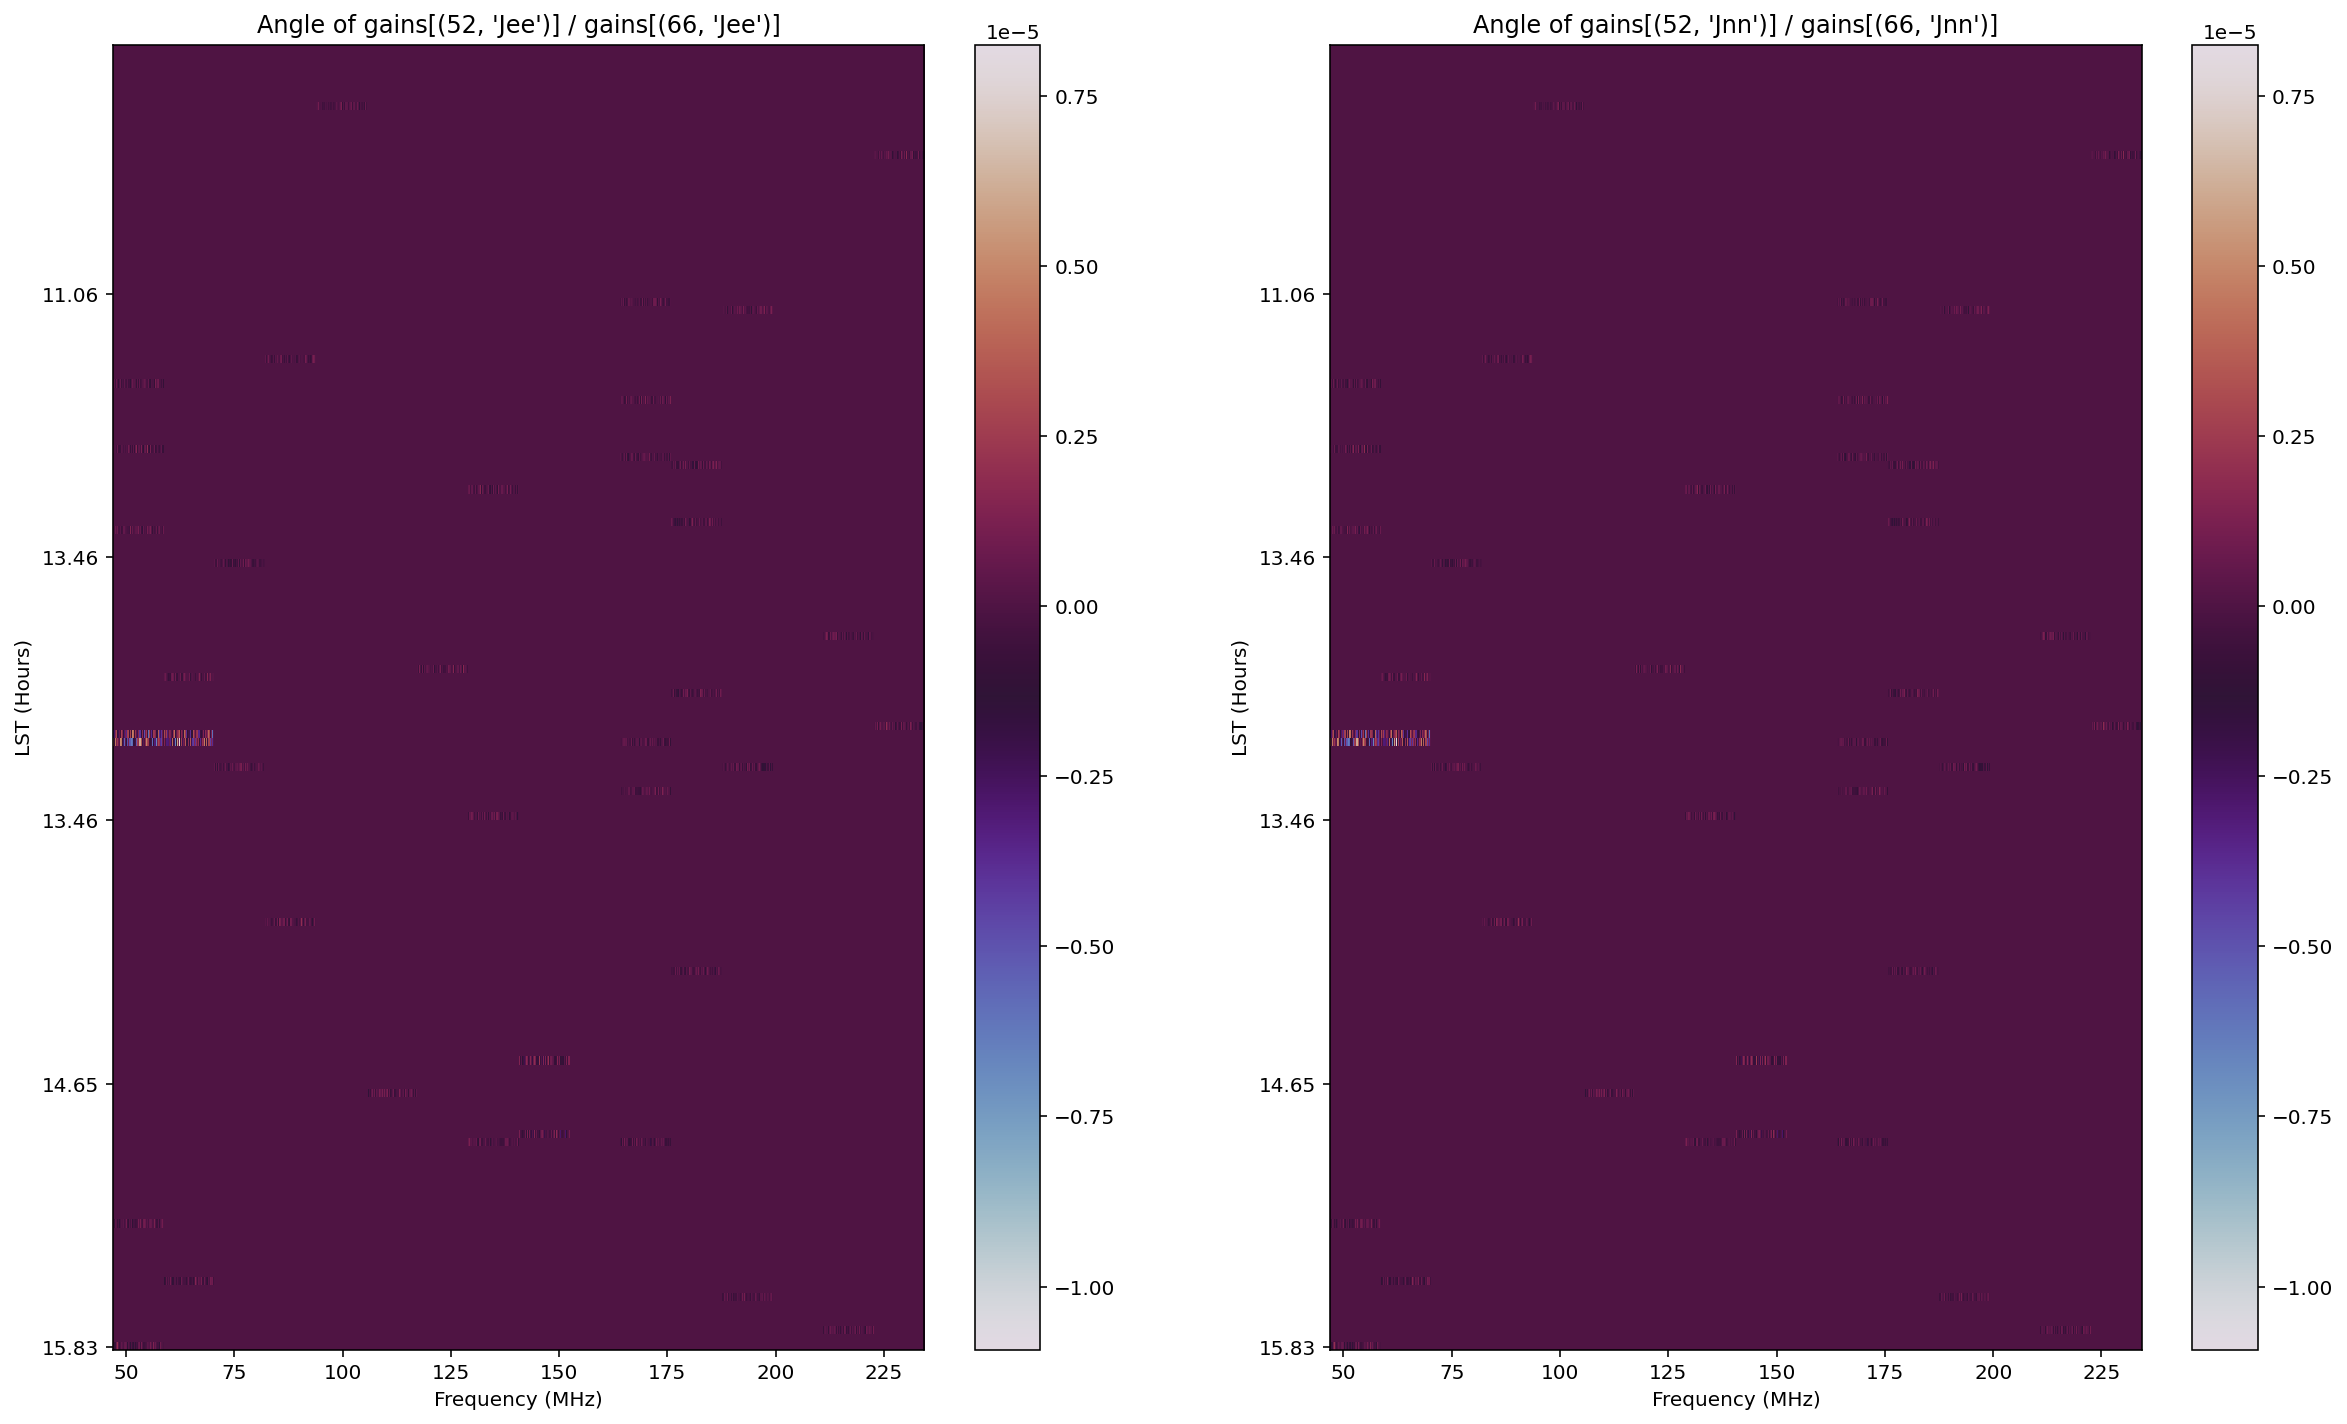

In [25]:
# Plot example gain relative phases
plt.figure(figsize=(20,12))
for sp, pol in zip([121, 122], ['Jee', 'Jnn']):
    plt.subplot(sp)
    ant0, ant1 = ants_to_save[pol]
    plt.title('Angle of gains[{}] / gains[{}]'.format(ant0, ant1))
    plt.imshow(np.angle(gains[ant0] / gains[ant1]), aspect='auto', cmap='twilight', interpolation='nearest',
               extent=[freqs[0]/1e6, freqs[-1]/1e6, times[-1], times[0]])
    plt.gca().set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) 
                                              for t in plt.gca().get_yticks()]] * 12 / np.pi, 2))    
    plt.colorbar()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('LST (Hours)')        

### Figure 11: Example Gain Phases
Relative gain phases of two example antennas.

#### OBSERVER CHECKLIST:
* Check that these gains are relatively stable in time and that there aren't huge phase discontinuities.

# Metadata

In [26]:
print(redcal.version.history_string())


------------
This file was produced by the function <module>() in 60442015.py using: 
    git_branch: main
    git_description: v3.0-1538-g00e4033
    git_hash: 00e4033fd61db04f3d2e7ef522c0c52261ac1fc6
    git_origin: https://github.com/HERA-Team/hera_cal.git
    version: 3.0
------------

